<a href="https://colab.research.google.com/github/AvantiShri/DeepCAC/blob/main/DeepCAC_port_to_python_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pynrrd
!pip install SimpleITK

In [ ]:
!git clone https://github.com/AvantiShri/DeepCAC.git

fatal: destination path 'DeepCAC' already exists and is not an empty directory.


In [ ]:
%cd /content/DeepCAC/src
!ls

/content/DeepCAC/src
config				   run_step1_heart_localization.py  step1_heartloc
DeepCAC				   run_step2_heart_segmentation.py  step1_model_w_weights.keras
model_without_weights_loaded.hdf5  run_step3_cac_segmentation.py    step2_heartseg
README.md			   run_step4_cac_scoring.py	    step3_cacseg


In [ ]:
!git pull

remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (5/5), done.
Unpacking objects: 100% (5/5), 1.05 KiB | 538.00 KiB/s, done.
remote: Total 5 (delta 4), reused 0 (delta 0), pack-reused 0
From https://github.com/AvantiShri/DeepCAC
   4b4c333..7ebc8cf  main       -> origin/main
Updating 4b4c333..7ebc8cf
Fast-forward
 src/step2_heartseg/heartseg_model.py | 8 ++++----
 1 file changed, 4 insertions(+), 4 deletions(-)


In [ ]:
!python run_step1_heart_localization.py


--- STEP 1 - HEART LOCALIZATION ---

Data preprocessing:
Found 4 patients under "/content/DeepCAC/data/raw"
Processing patient 0909
Processing patient 0987
Processing patient 0187
Processing patient 0506

Data downsampling:
Found 4 patients under "/content/DeepCAC/data/step1_heartloc/curated" folder.
Processing patient 0987
Processing patient 0909
Processing patient 0506
Processing patient 0187
Saving results dictionary...

Input data preparation:
Loading input data from "/content/DeepCAC/data/step1_heartloc/resampled"
Found 4 patients under "/content/DeepCAC/data/step1_heartloc/resampled" folder.
Writing data file... 
Processing patient 0987
Processing patient 0909
Processing patient 0506
Processing patient 0187

Deep Learning model inference:
Input values are:
outdir path /content/DeepCAC/data/step1_heartloc/model_output indir path /content/DeepCAC/data/step1_heartloc/model_input model weights /content/DeepCAC/data/step1_heartloc/model_weights crop size 112 export png True down step

In [ ]:
import keras
from keras.saving import load_model

#from heartloc_model.py
def dice_coef(y_true, y_pred, smooth=1.):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

## ----------------------------------------
## ----------------------------------------

def dice_coef_loss(y_true, y_pred):
  return -dice_coef(y_true, y_pred)


model_without_weights = load_model(
    "model_without_weights_loaded.hdf5",
    custom_objects={"dice_coef_loss": dice_coef_loss,
                    "dice_coef": dice_coef})

In [ ]:
import tables
import pickle
import os
import numpy as np

#copied from https://github.com/AIM-Harvard/DeepCAC/blob/a1c2cd3b0ce082f047e042c1581b556ab08b0f77/src/step1_heartloc/run_inference.py#L68C3-L105C1
def get_input_data_to_model(dataDir, test_file, pkl_file, has_manual_seg, mgpu):
  testFileHdf5 = tables.open_file(os.path.join(dataDir, test_file), "r")
  pklData = pickle.load(open(os.path.join(dataDir, pkl_file), 'rb'))

  # Get data in one list for further processing
  testDataRaw = []
  num_test_imgs = len(testFileHdf5.root.ID)
  print(num_test_imgs)
  for i in range(num_test_imgs):
    patientID = (testFileHdf5.root.ID[i]).decode("utf-8") #python 2 to python 3 difference
    img = testFileHdf5.root.img[i]
    if has_manual_seg:
      msk = testFileHdf5.root.msk[i]
    else:  # Create empty dummy has_manual_seg with same size as the image
      sizeImg = len(img)
      msk = np.zeros((sizeImg, sizeImg, sizeImg), dtype=np.float64)
    print(pklData.keys())
    if not patientID in pklData.keys():
      print('Patient not found in pkl data', patientID)
      continue
    zDif = pklData[patientID][6][2]
    testDataRaw.append([patientID, img, msk, zDif])

  numData = len(testDataRaw)
  size = len(testDataRaw[0][1])
  imgsTrue = np.zeros((numData, size, size, size), dtype=np.float64)
  msksTrue = np.zeros((numData, size, size, size), dtype=np.float64)

  for i in range(0, len(testDataRaw) + 1, mgpu):
    imgTest = np.zeros((4, size, size, size), dtype=np.float64)

    for j in range(mgpu):
      # If the number of test images is not mod 4 == 0, just redo the last file severall times
      patientIndex = min(len(testDataRaw) - 1, i + j)
      patientID = testDataRaw[patientIndex][0]
      print('Processing patient', patientID)
      # Store data for score calculation
      imgsTrue[patientIndex, :, :, :] = testDataRaw[patientIndex][1]
      msksTrue[patientIndex, :, :, :] = testDataRaw[patientIndex][2]
      imgTest[j, :, :, :] = testDataRaw[patientIndex][1]

  return imgTest, msksTrue

input_data_to_model, inputMasks = get_input_data_to_model(
    dataDir="/content/DeepCAC/data/step1_heartloc/model_input", #model_input_dir_path
    test_file="step1_test_data.h5",
    pkl_file="step1_downsample_results.pkl",
    has_manual_seg=True,
    mgpu=1)


4
dict_keys(['0987', '0909', '0506', '0187'])
dict_keys(['0987', '0909', '0506', '0187'])
dict_keys(['0987', '0909', '0506', '0187'])
dict_keys(['0987', '0909', '0506', '0187'])
Processing patient 0987
Processing patient 0909
Processing patient 0506
Processing patient 0187
Processing patient 0187


In [ ]:
inputMasks.shape

(4, 112, 112, 112)

In [ ]:
model_preds_noweightsloaded = model_without_weights.predict(input_data_to_model[0:1])

1/1 [==============================] - 28s 28s/step


In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

def sliceplot_z(np_array, ncols, stepsize, figsizepercol=4):
    plotdimlen = np_array.shape[2]
    numplots = int(plotdimlen/stepsize)
    nrows=int(np.ceil(numplots/ncols))
    fig, ax = plt.subplots(nrows=nrows,
                           ncols=ncols,
                           figsize=(ncols*figsizepercol,
                                    nrows*figsizepercol))
    for plotidx,i in enumerate(range(0, plotdimlen, stepsize)):
        plt.sca(ax[int(plotidx/ncols), plotidx%ncols])
        plt.imshow(np_array[:,:,i])
        plt.title("z="+str(i))
    plt.show()



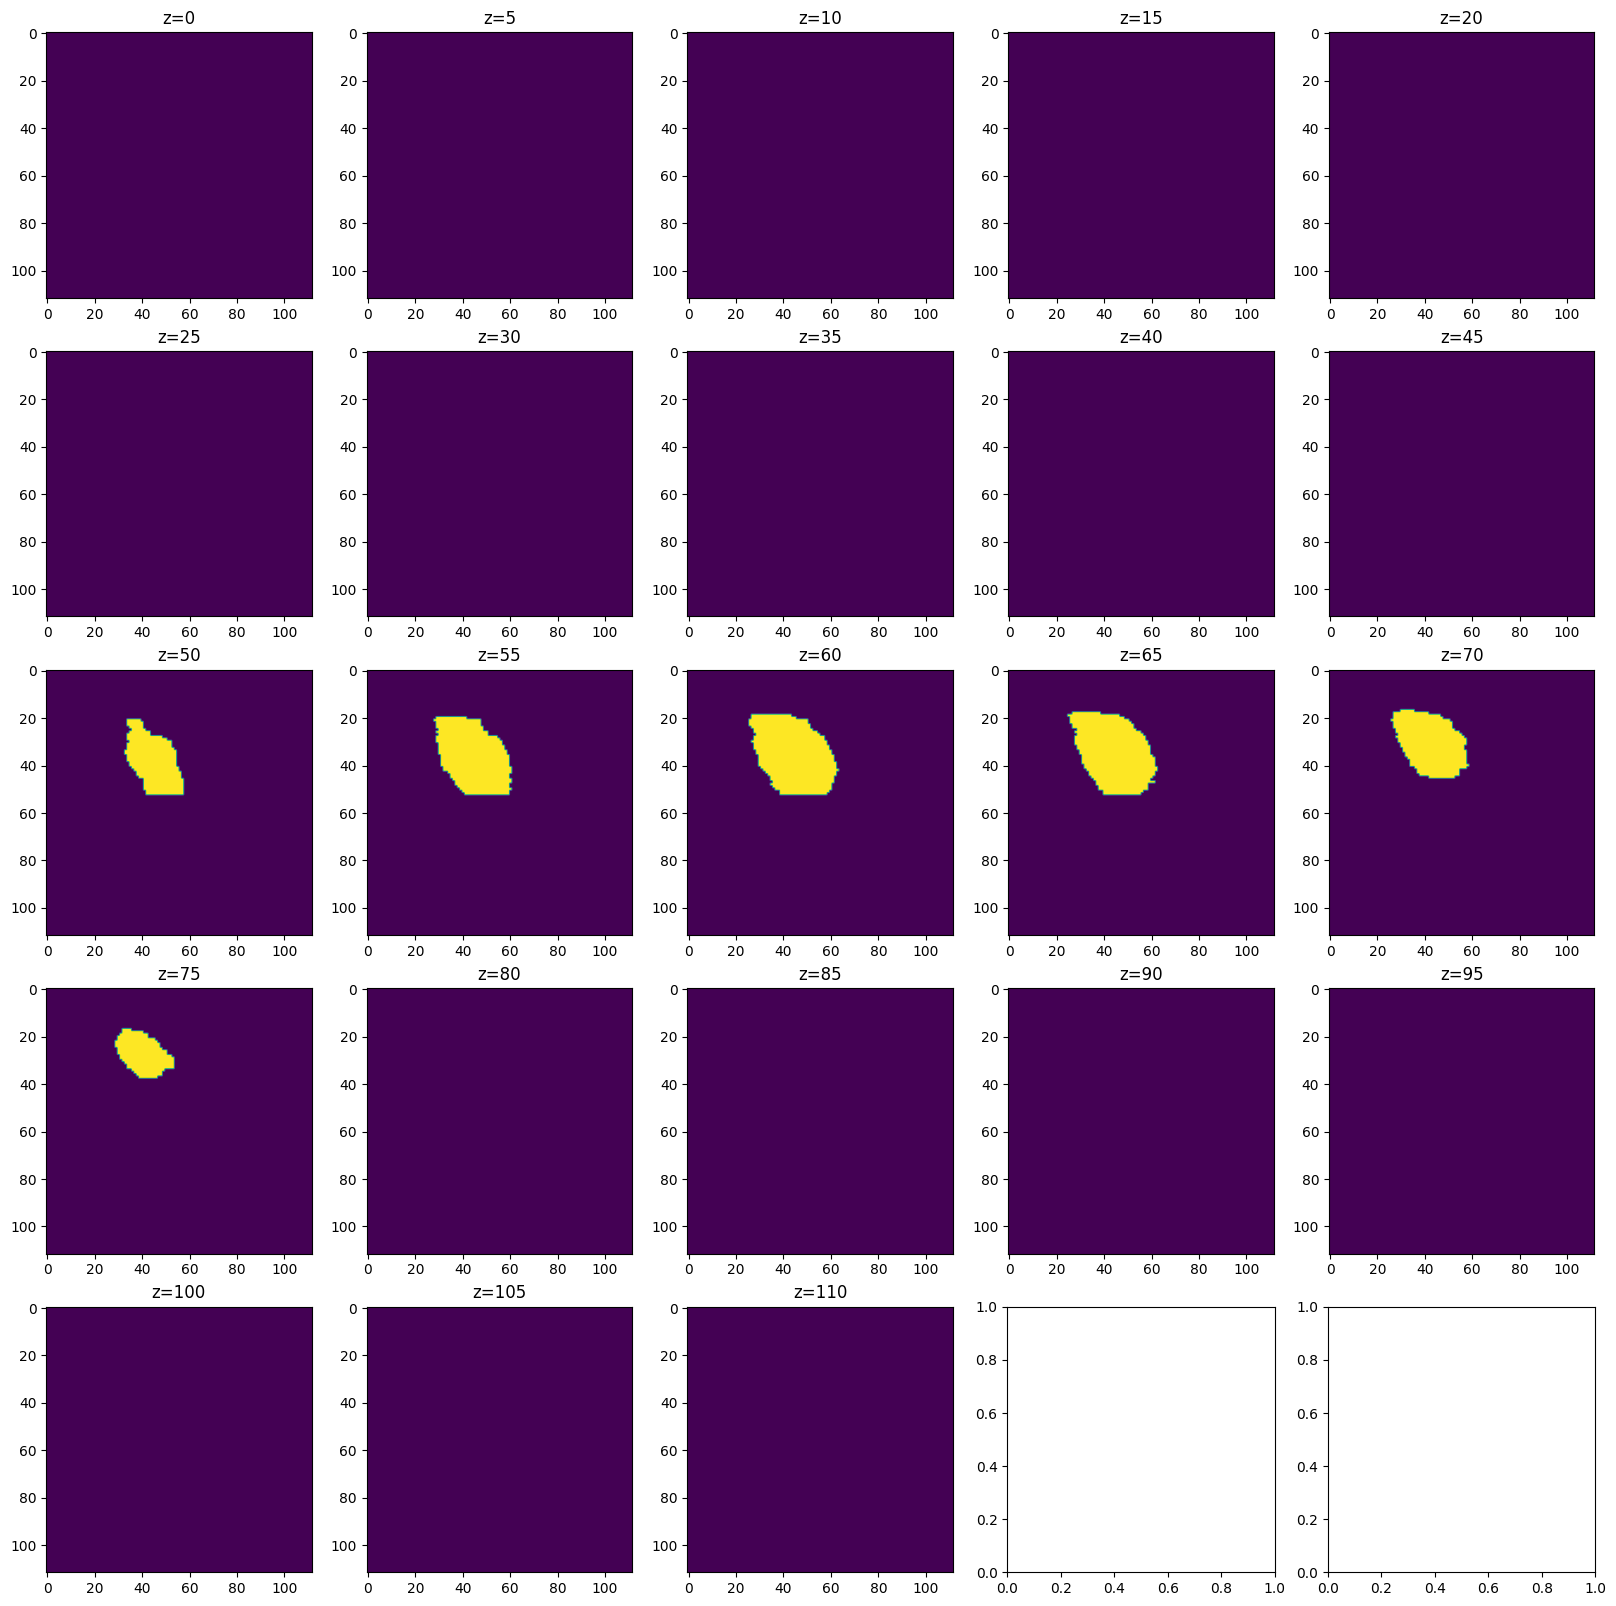

In [ ]:
sliceplot_z(inputMasks[0], ncols=5, stepsize=5)

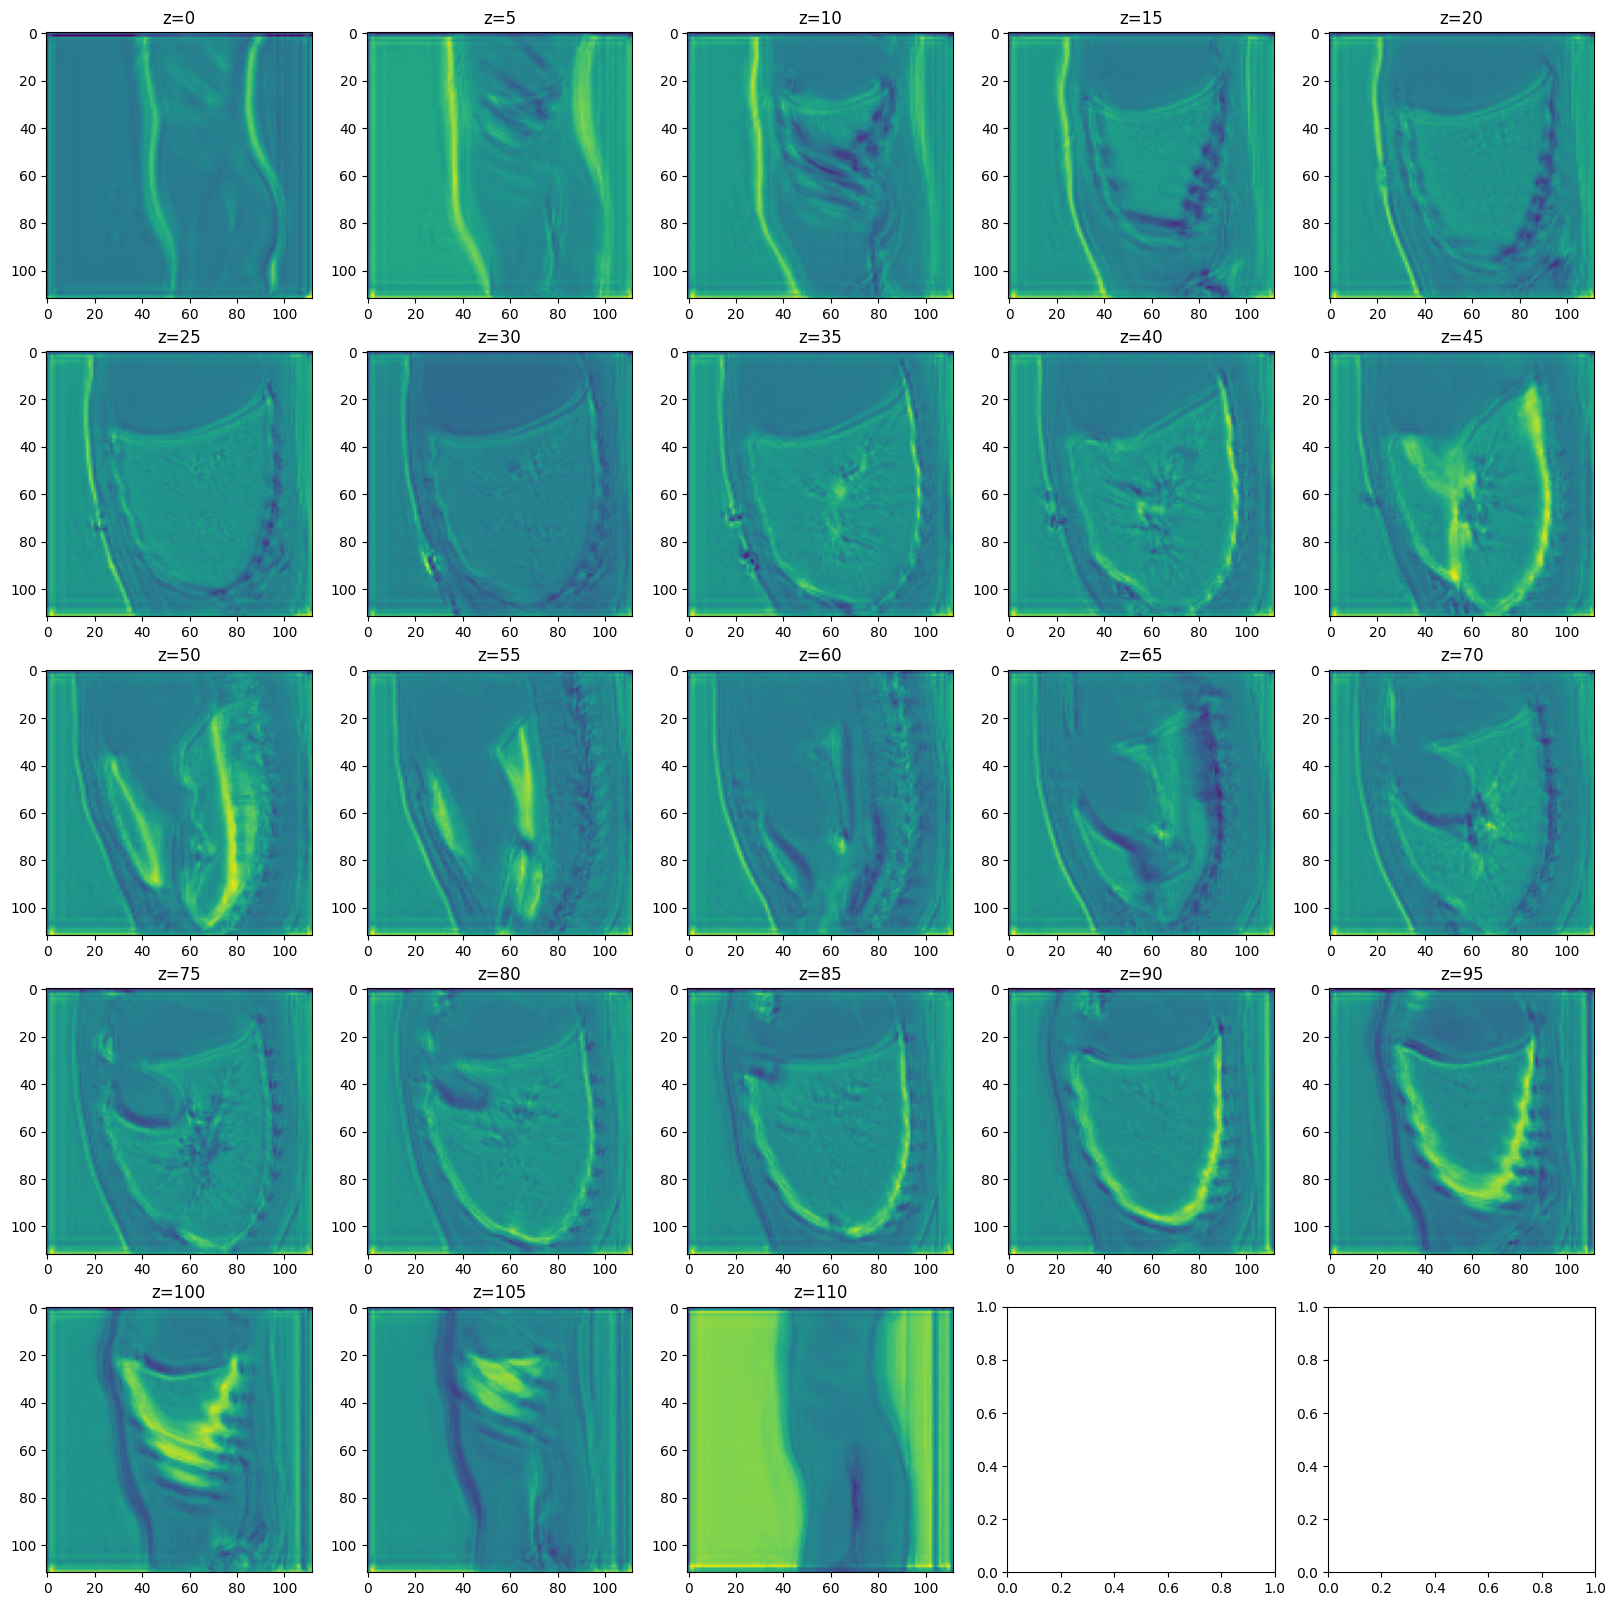

In [ ]:
sliceplot_z(model_preds_noweightsloaded[0].squeeze(), ncols=5, stepsize=5)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Loading the weights from hdf5 to npy
import h5py
import numpy as np
f = h5py.File("/content/DeepCAC/data/step1_heartloc/model_weights/step1_heartloc_model_weights.hdf5", "r")
f['model_1'].keys()

<KeysViewHDF5 ['conv_10', 'conv_1_1', 'conv_1_2', 'conv_2_1', 'conv_2_2', 'conv_3_1', 'conv_3_2', 'conv_4_1', 'conv_4_2', 'conv_5_1', 'conv_5_2', 'conv_6_1', 'conv_6_2', 'conv_7_1', 'conv_7_2', 'conv_8_1', 'conv_8_2', 'conv_9_1', 'conv_9_2']>

Loaded the weights for model 1.
There are some layers with no weights. Not sure why.
Try:

In [ ]:
model_without_weights.layers[3].name

'pool_1'

In [ ]:
#setting the weights of each layer
conv_1_1_b = np.array(f['model_1']['conv_1_1']['bias:0'])
conv_1_1_k = np.array(f['model_1']['conv_1_1']['kernel:0'])
model_without_weights.layers[1].set_weights([conv_1_1_k, conv_1_1_b])
conv_1_2_b = np.array(f['model_1']['conv_1_2']['bias:0'])
conv_1_2_k = np.array(f['model_1']['conv_1_2']['kernel:0'])
model_without_weights.layers[2].set_weights([conv_1_2_k, conv_1_2_b])
conv_2_1_b = np.array(f['model_1']['conv_2_1']['bias:0'])
conv_2_1_k = np.array(f['model_1']['conv_2_1']['kernel:0'])
model_without_weights.layers[4].set_weights([conv_2_1_k, conv_2_1_b])
conv_2_2_b = np.array(f['model_1']['conv_2_2']['bias:0'])
conv_2_2_k = np.array(f['model_1']['conv_2_2']['kernel:0'])
model_without_weights.layers[5].set_weights([conv_2_2_k, conv_2_2_b])
conv_3_1_b = np.array(f['model_1']['conv_3_1']['bias:0'])
conv_3_1_k = np.array(f['model_1']['conv_3_1']['kernel:0'])
model_without_weights.layers[7].set_weights([conv_3_1_k, conv_3_1_b])
conv_3_2_b = np.array(f['model_1']['conv_3_2']['bias:0'])
conv_3_2_k = np.array(f['model_1']['conv_3_2']['kernel:0'])
model_without_weights.layers[8].set_weights([conv_3_2_k, conv_3_2_b])
conv_4_1_b = np.array(f['model_1']['conv_4_1']['bias:0'])
conv_4_1_k = np.array(f['model_1']['conv_4_1']['kernel:0'])
model_without_weights.layers[10].set_weights([conv_4_1_k, conv_4_1_b])
conv_4_2_b = np.array(f['model_1']['conv_4_2']['bias:0'])
conv_4_2_k = np.array(f['model_1']['conv_4_2']['kernel:0'])
model_without_weights.layers[11].set_weights([conv_4_2_k, conv_4_2_b])
conv_5_1_b = np.array(f['model_1']['conv_5_1']['bias:0'])
conv_5_1_k = np.array(f['model_1']['conv_5_1']['kernel:0'])
model_without_weights.layers[13].set_weights([conv_5_1_k, conv_5_1_b])
conv_5_2_b = np.array(f['model_1']['conv_5_2']['bias:0'])
conv_5_2_k = np.array(f['model_1']['conv_5_2']['kernel:0'])
model_without_weights.layers[14].set_weights([conv_5_2_k, conv_5_2_b])
conv_6_1_b = np.array(f['model_1']['conv_6_1']['bias:0'])
conv_6_1_k = np.array(f['model_1']['conv_6_1']['kernel:0'])
model_without_weights.layers[17].set_weights([conv_6_1_k, conv_6_1_b])
conv_6_2_b = np.array(f['model_1']['conv_6_2']['bias:0'])
conv_6_2_k = np.array(f['model_1']['conv_6_2']['kernel:0'])
model_without_weights.layers[18].set_weights([conv_6_2_k, conv_6_2_b])
conv_7_1_b = np.array(f['model_1']['conv_7_1']['bias:0'])
conv_7_1_k = np.array(f['model_1']['conv_7_1']['kernel:0'])
model_without_weights.layers[21].set_weights([conv_7_1_k, conv_7_1_b])
conv_7_2_b = np.array(f['model_1']['conv_7_2']['bias:0'])
conv_7_2_k = np.array(f['model_1']['conv_7_2']['kernel:0'])
model_without_weights.layers[22].set_weights([conv_7_2_k, conv_7_2_b])
conv_8_1_b = np.array(f['model_1']['conv_8_1']['bias:0'])
conv_8_1_k = np.array(f['model_1']['conv_8_1']['kernel:0'])
model_without_weights.layers[25].set_weights([conv_8_1_k, conv_8_1_b])
conv_8_2_b = np.array(f['model_1']['conv_8_2']['bias:0'])
conv_8_2_k = np.array(f['model_1']['conv_8_2']['kernel:0'])
model_without_weights.layers[26].set_weights([conv_8_2_k, conv_8_2_b])
conv_9_1_b = np.array(f['model_1']['conv_9_1']['bias:0'])
conv_9_1_k = np.array(f['model_1']['conv_9_1']['kernel:0'])
model_without_weights.layers[29].set_weights([conv_9_1_k, conv_9_1_b])
conv_9_2_b = np.array(f['model_1']['conv_9_2']['bias:0'])
conv_9_2_k = np.array(f['model_1']['conv_9_2']['kernel:0'])
model_without_weights.layers[30].set_weights([conv_9_2_k, conv_9_2_b])
conv_10_b = np.array(f['model_1']['conv_10']['bias:0'])
conv_10_k = np.array(f['model_1']['conv_10']['kernel:0'])
model_without_weights.layers[31].set_weights([conv_10_k, conv_10_b])

#make sure input_data_to_model is prepared befor this point
model_preds_weightsloaded = model_without_weights.predict(input_data_to_model[0:1])
model = model_without_weights


1/1 [==============================] - 28s 28s/step


In [ ]:
#saving the new model with the weights
import os
import tensorflow as tf
from tensorflow import keras
model.save('step1_model_w_weights.keras') # Saves the entire model as a `.keras` zip archive.


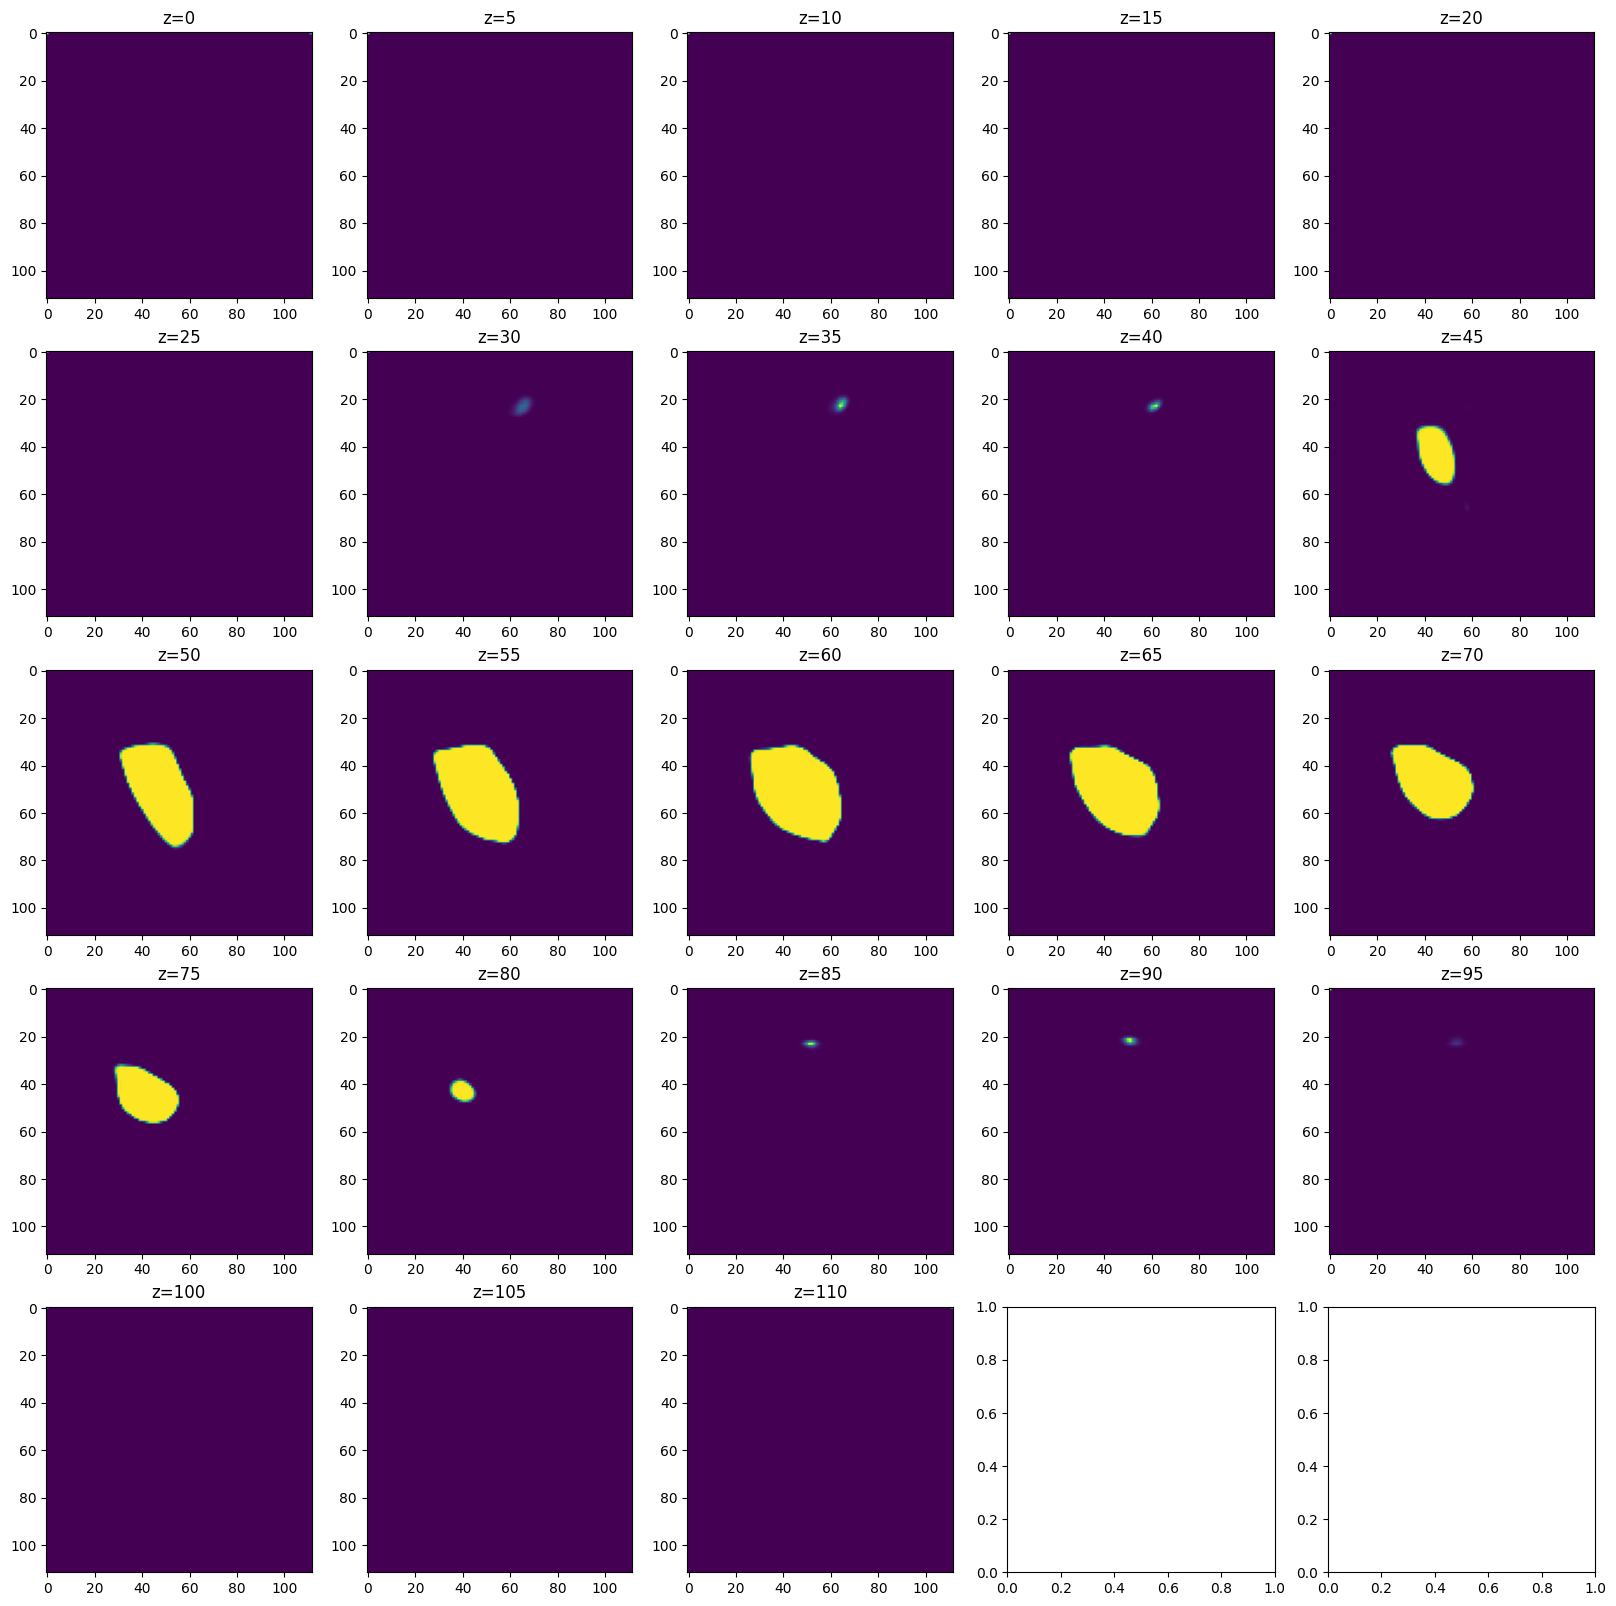

In [ ]:
sliceplot_z(model_preds_weightsloaded[0].squeeze(), ncols=5, stepsize=5)

In [ ]:
dataDir="/content/DeepCAC/data/step1_heartloc/model_input" #model_input_dir_path
test_file="step1_test_data.h5"
pkl_file="step1_downsample_results.pkl"
has_manual_seg=True
mgpu=1
model_output_dir_path = "/content/DeepCAC/data/step1_heartloc/model_output"
model=model_without_weights

testFileHdf5 = tables.open_file(os.path.join(dataDir, test_file), "r")
pklData = pickle.load(open(os.path.join(dataDir, pkl_file), 'rb'))
  # Get data in one list for further processing
testDataRaw = []
num_test_imgs = len(testFileHdf5.root.ID)
print(num_test_imgs)
for i in range(num_test_imgs):
  patientID = (testFileHdf5.root.ID[i]).decode("utf-8") #python 2 to python 3 difference
  img = testFileHdf5.root.img[i]
  if has_manual_seg:
    msk = testFileHdf5.root.msk[i]
  else:  # Create empty dummy has_manual_seg with same size as the image
    sizeImg = len(img)
    msk = np.zeros((sizeImg, sizeImg, sizeImg), dtype=np.float64)
  print(pklData.keys())
  if not patientID in pklData.keys():
    print('Patient not found in pkl data', patientID)
    continue
  zDif = pklData[patientID][6][2]
  testDataRaw.append([patientID, img, msk, zDif])

numData = len(testDataRaw)
size = len(testDataRaw[0][1])
imgsTrue = np.zeros((numData, size, size, size), dtype=np.float64)
msksTrue = np.zeros((numData, size, size, size), dtype=np.float64)

for i in range(len(testDataRaw)):
   imgsTrue[i, :, :, :] = testDataRaw[i][1]
   msksTrue[i, :, :, :] = testDataRaw[i][2]

msksPred = model.predict(imgsTrue[:, :, :, :, np.newaxis])
output_dir_npy = os.path.join(model_output_dir_path, 'npy')

for patientIndex in range(0, len(testDataRaw)):
  patientID = testDataRaw[patientIndex][0]
  np.save(os.path.join(output_dir_npy, patientID + '_pred'),
          [imgsTrue[patientIndex], msksTrue[patientIndex], msksPred[patientIndex, :, :, :, 0]])

4
dict_keys(['0987', '0909', '0506', '0187'])
dict_keys(['0987', '0909', '0506', '0187'])
dict_keys(['0987', '0909', '0506', '0187'])
dict_keys(['0987', '0909', '0506', '0187'])
1/1 [==============================] - 104s 104s/step


Input image


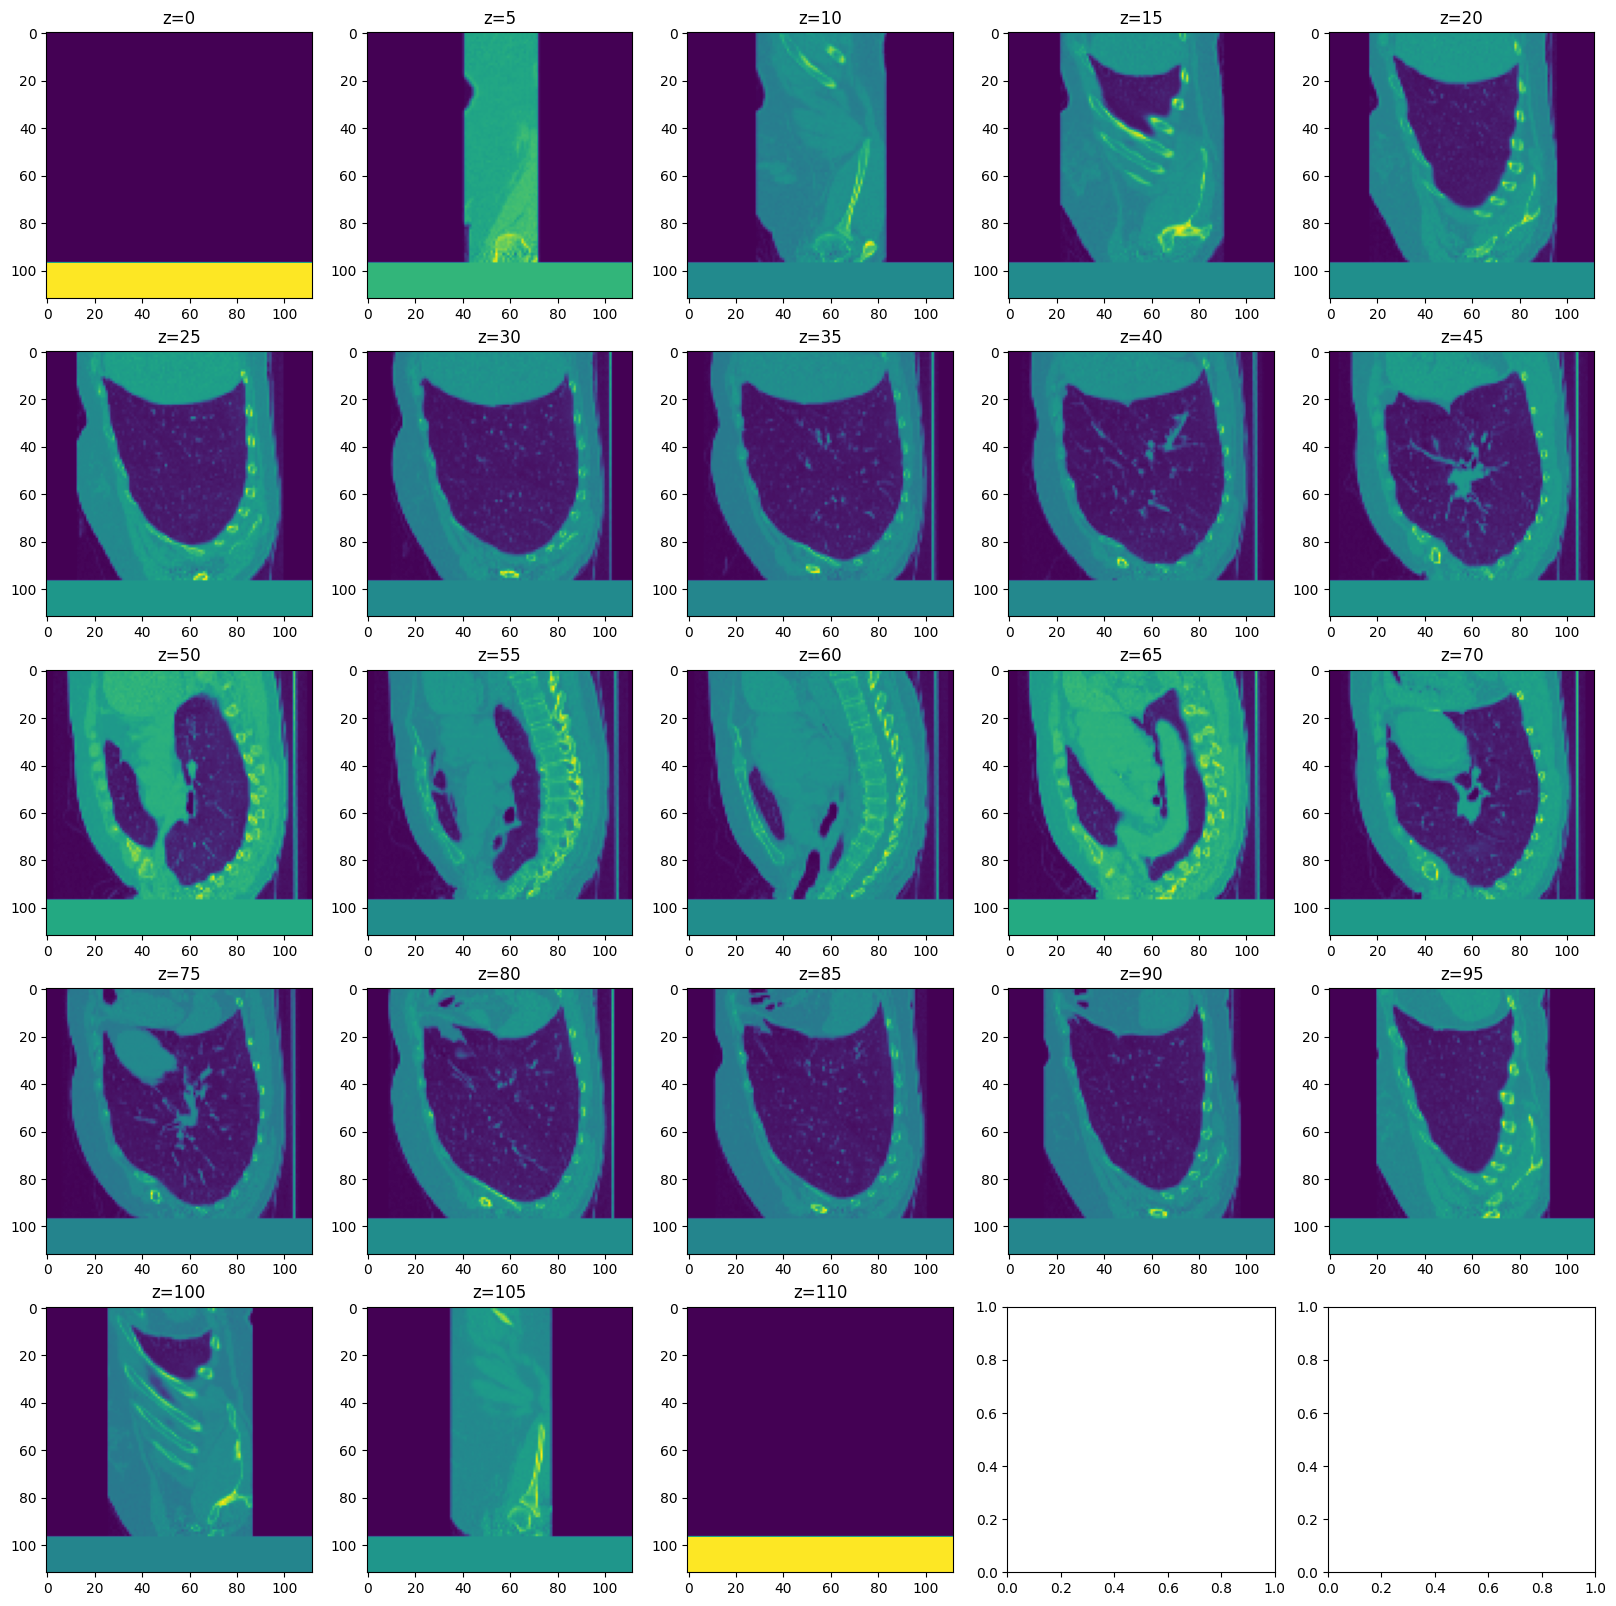

Prediction


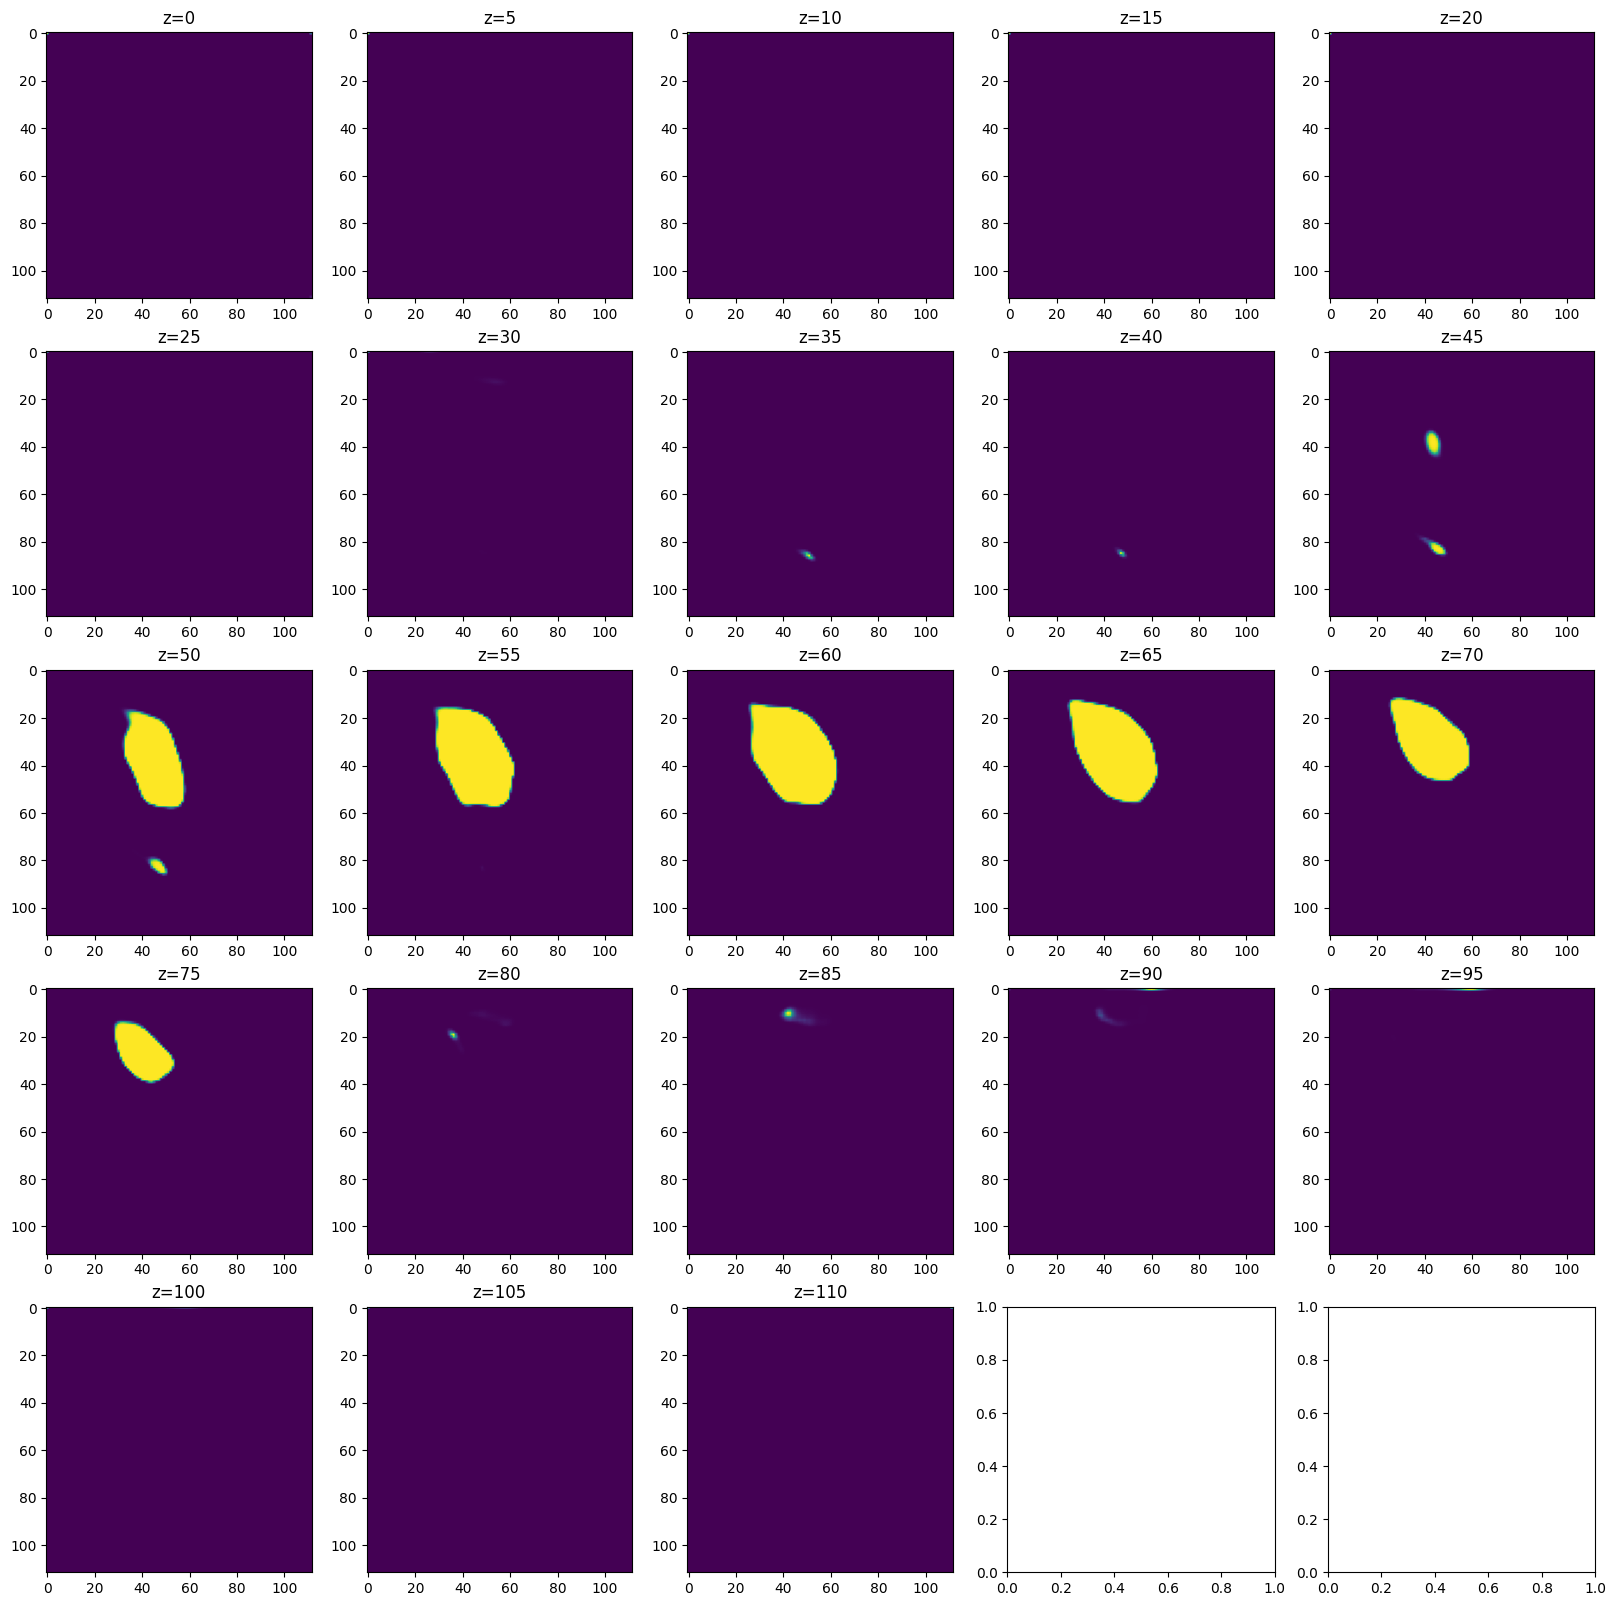

Input image


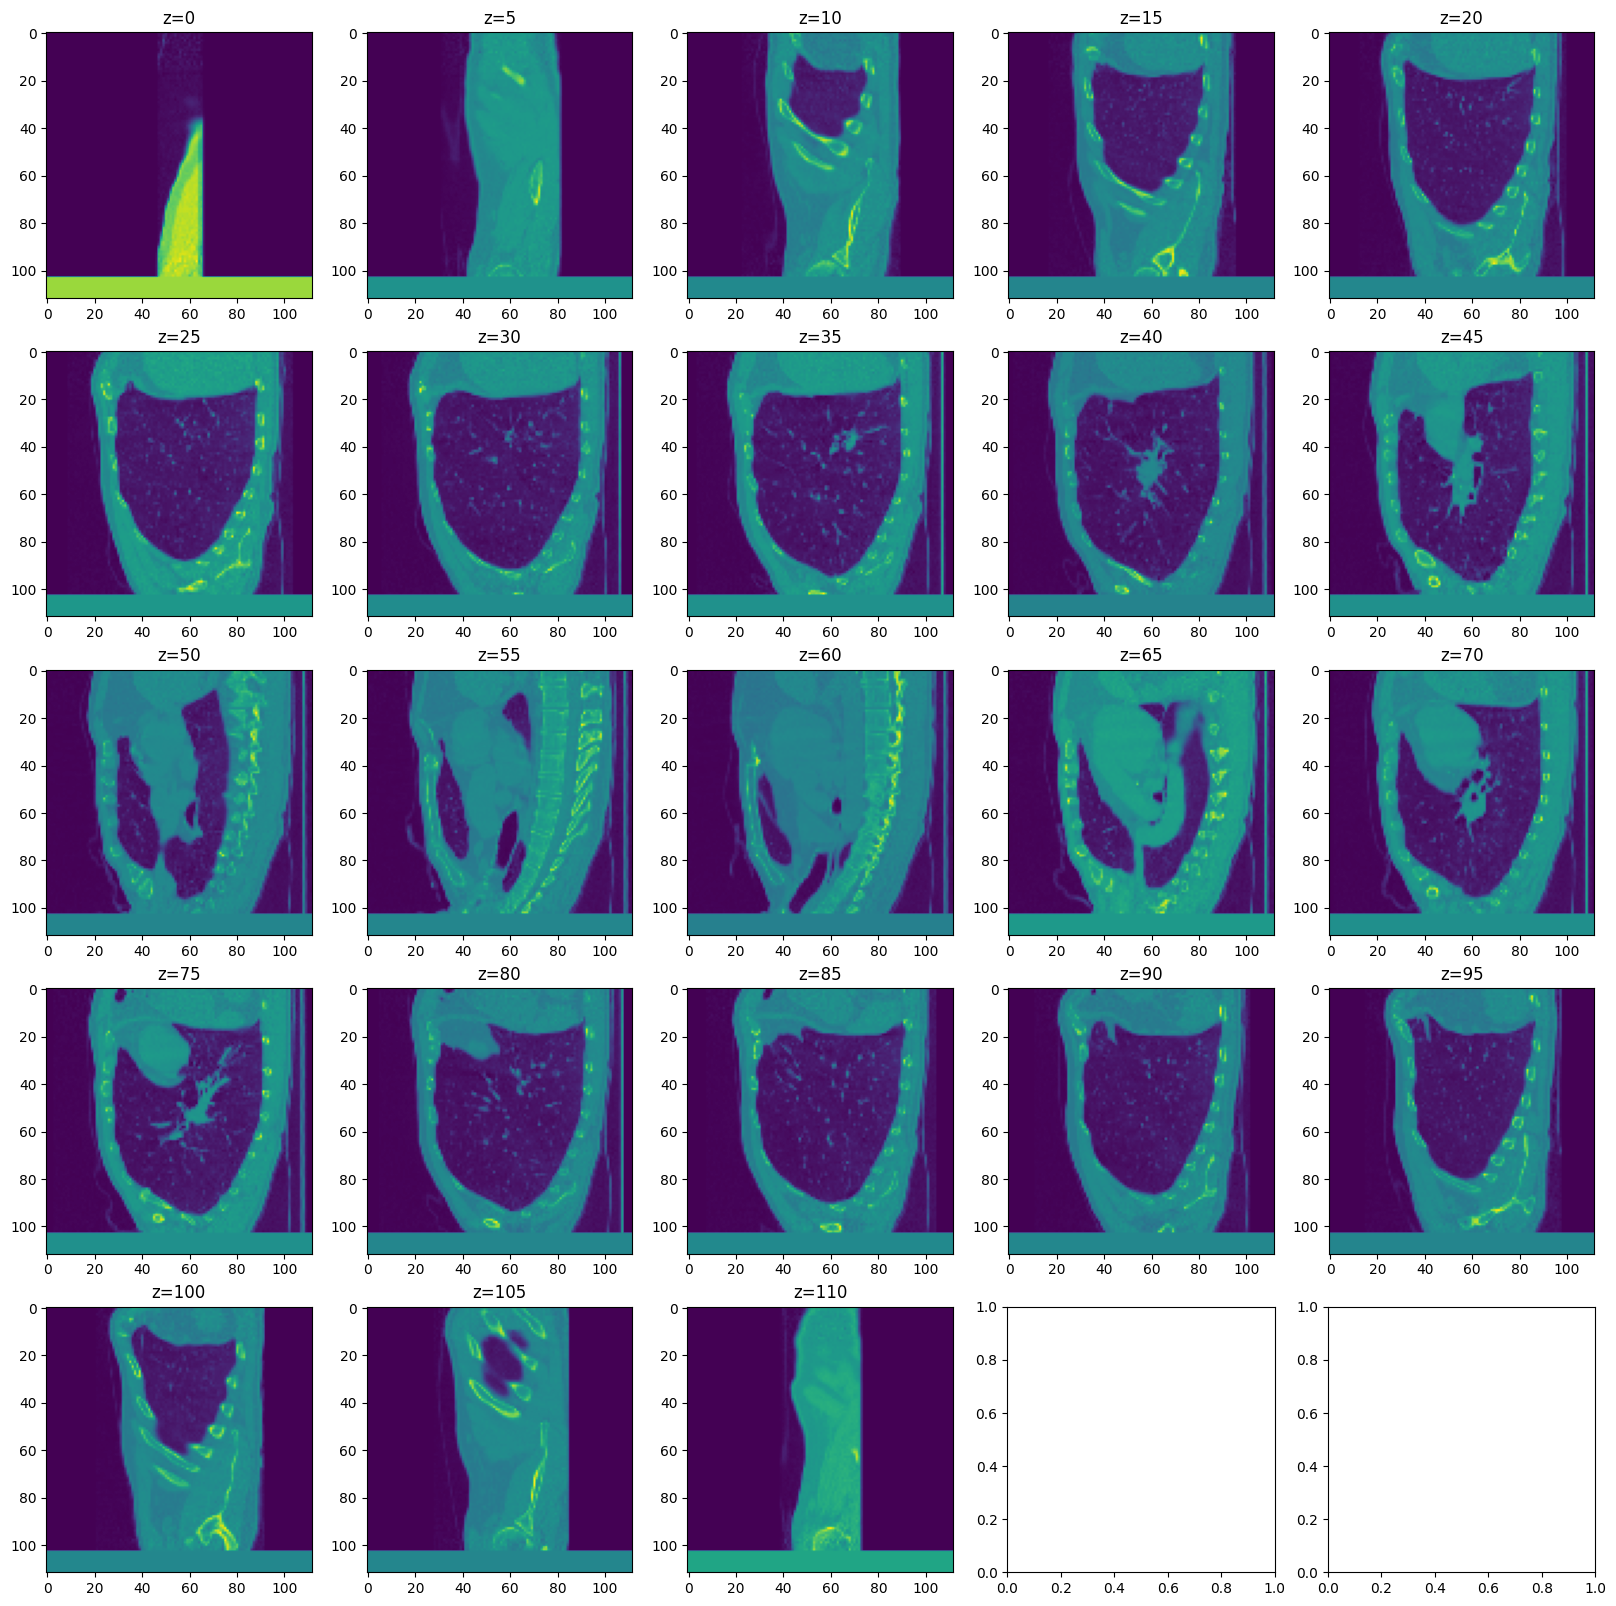

Prediction


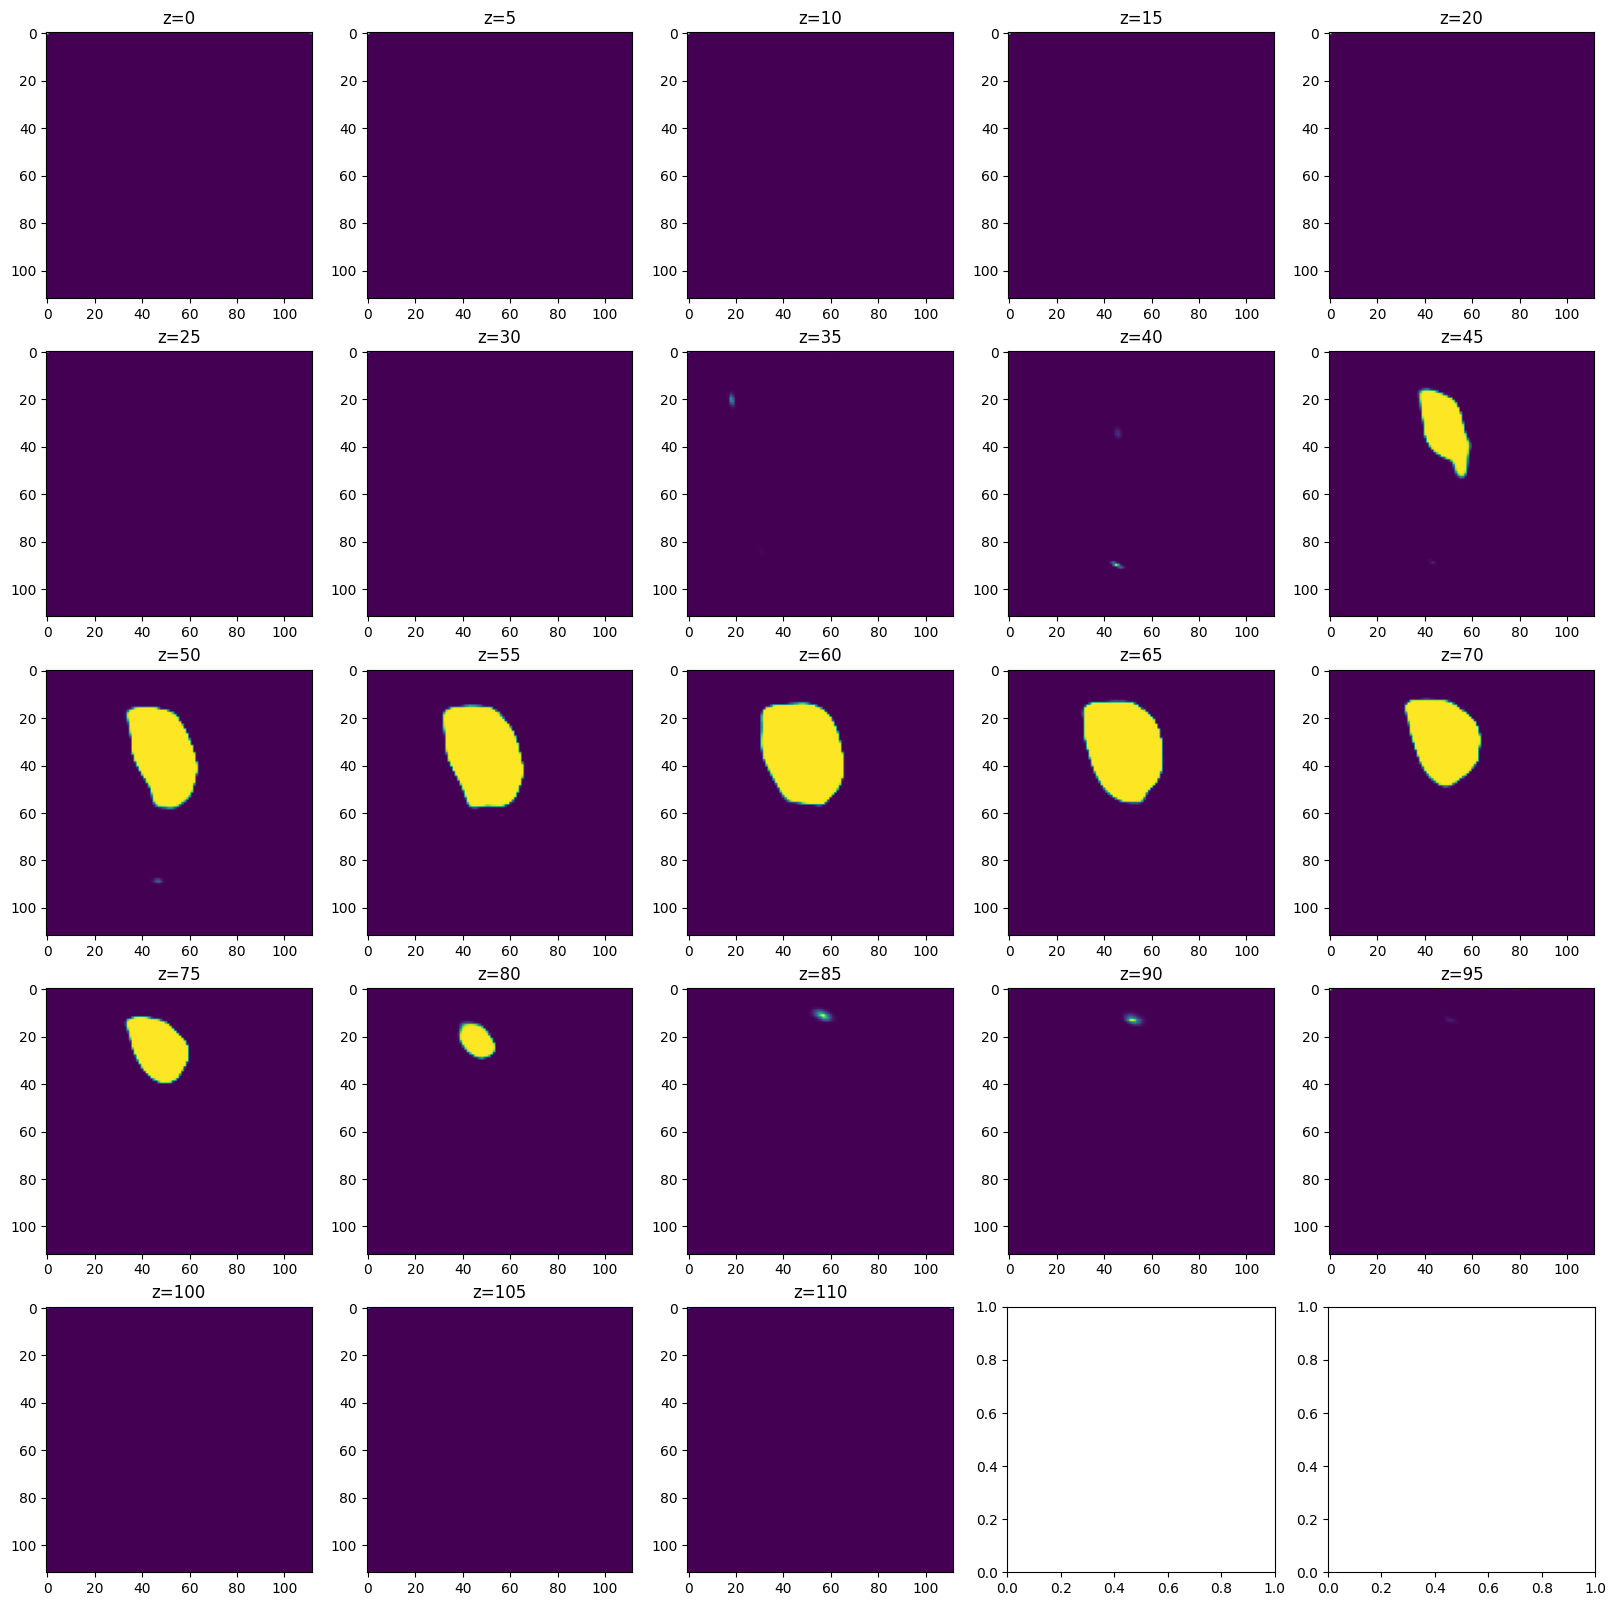

Input image


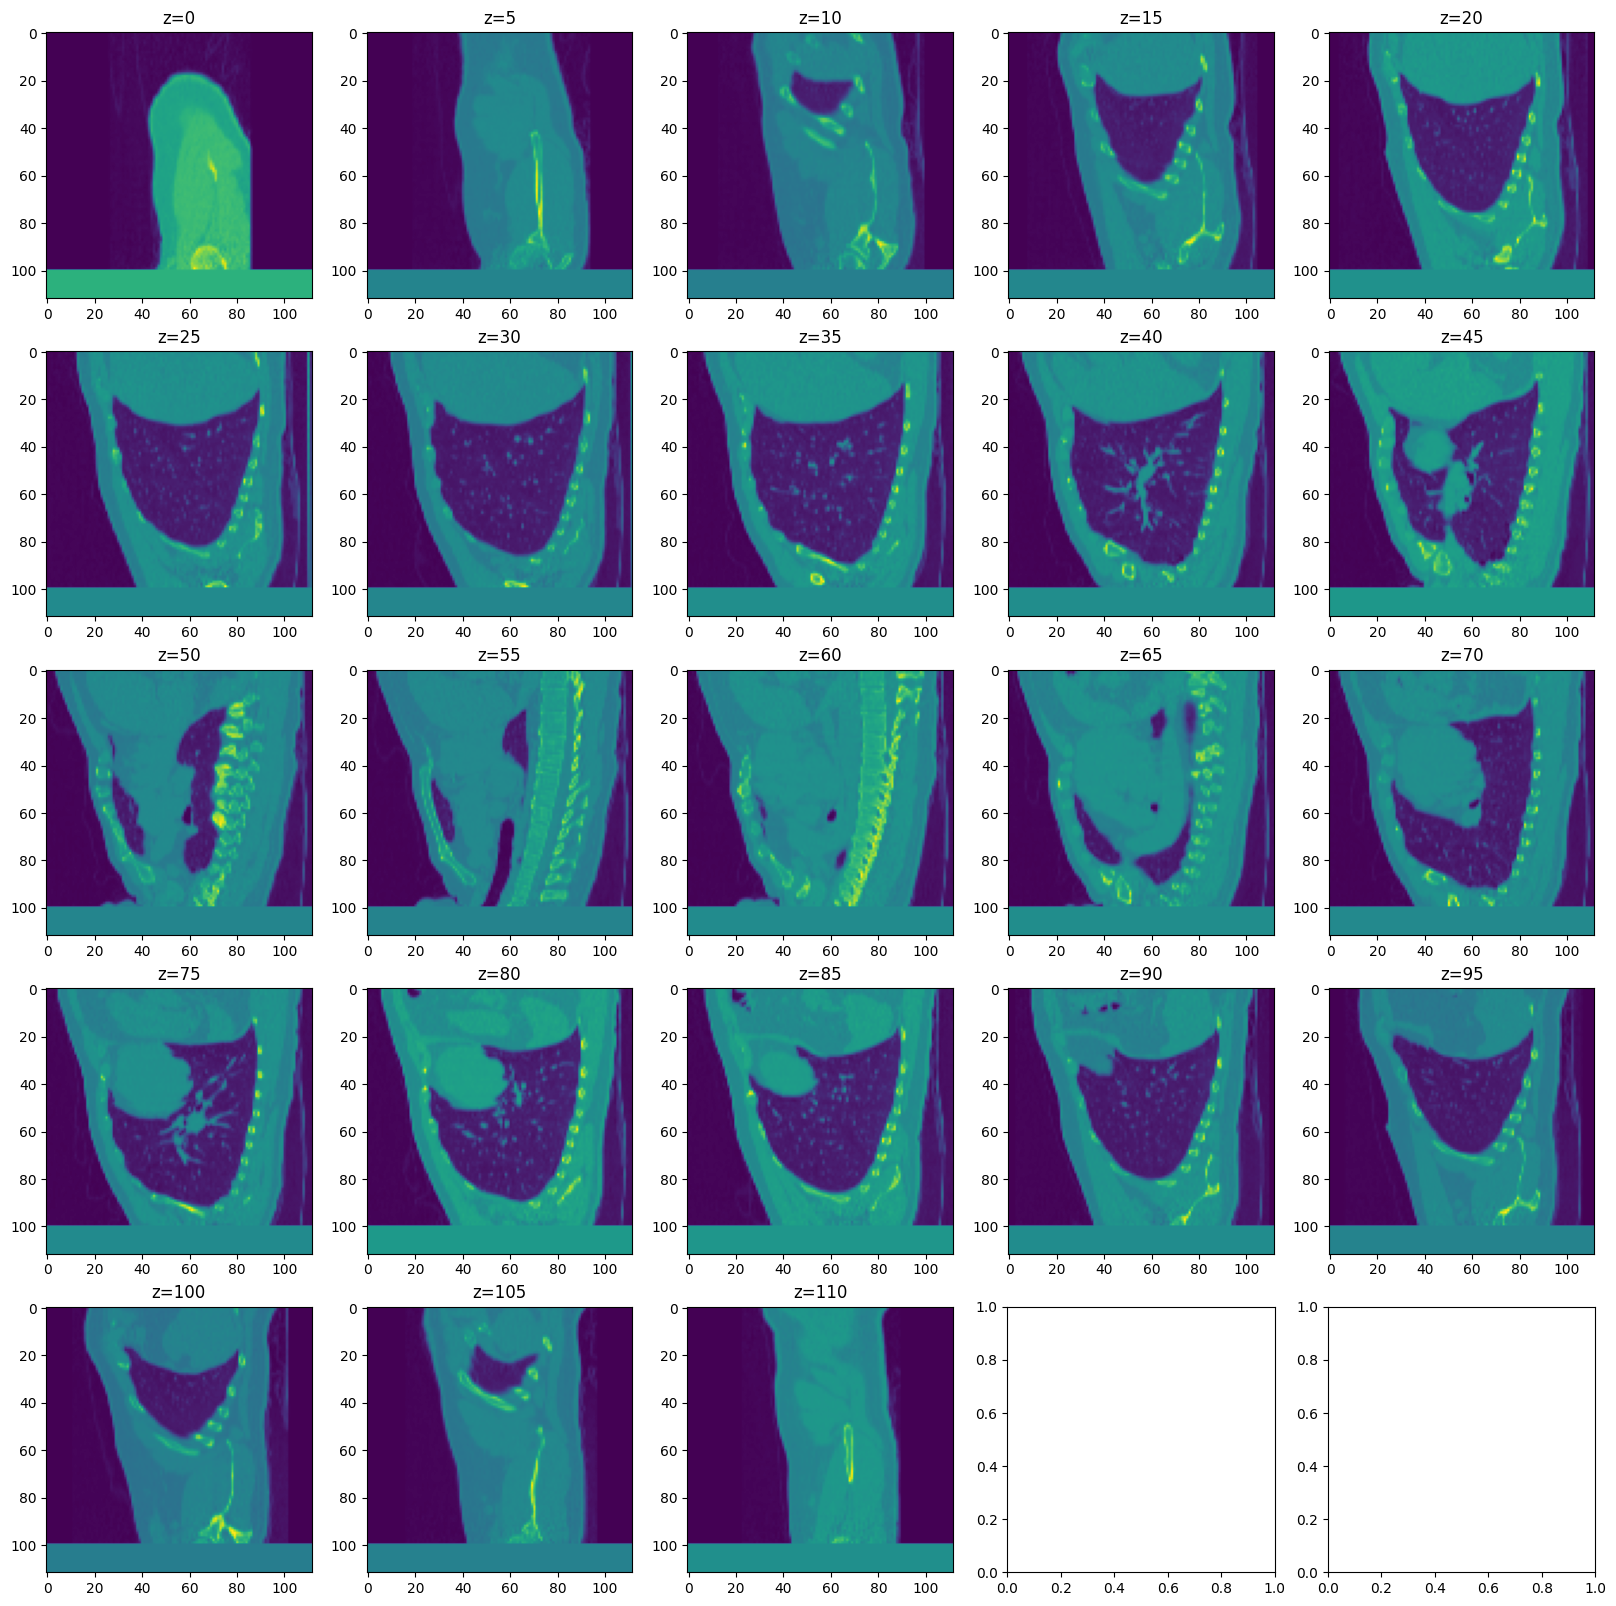

Prediction


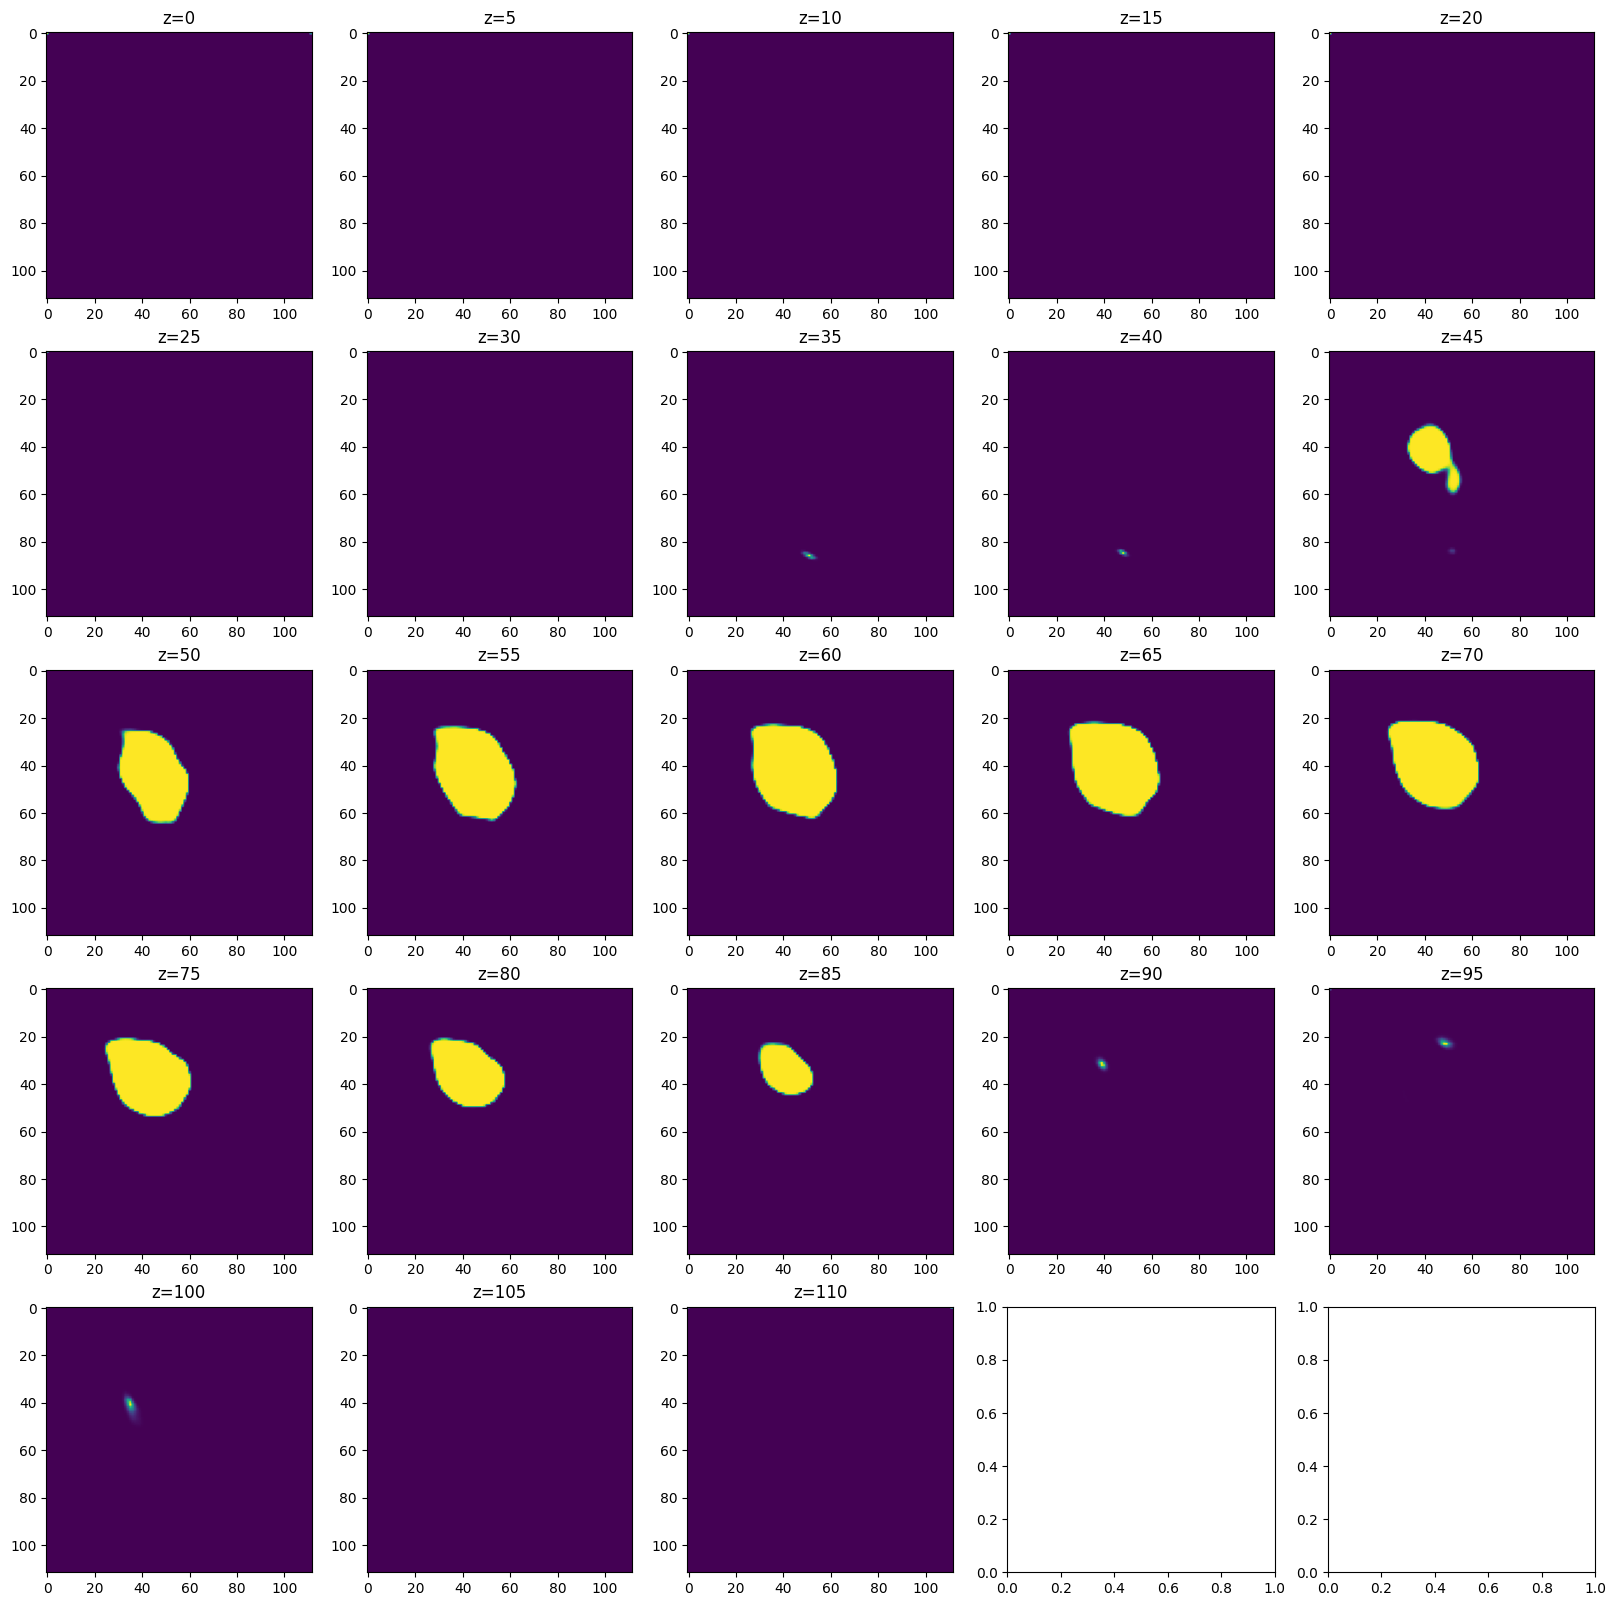

Input image


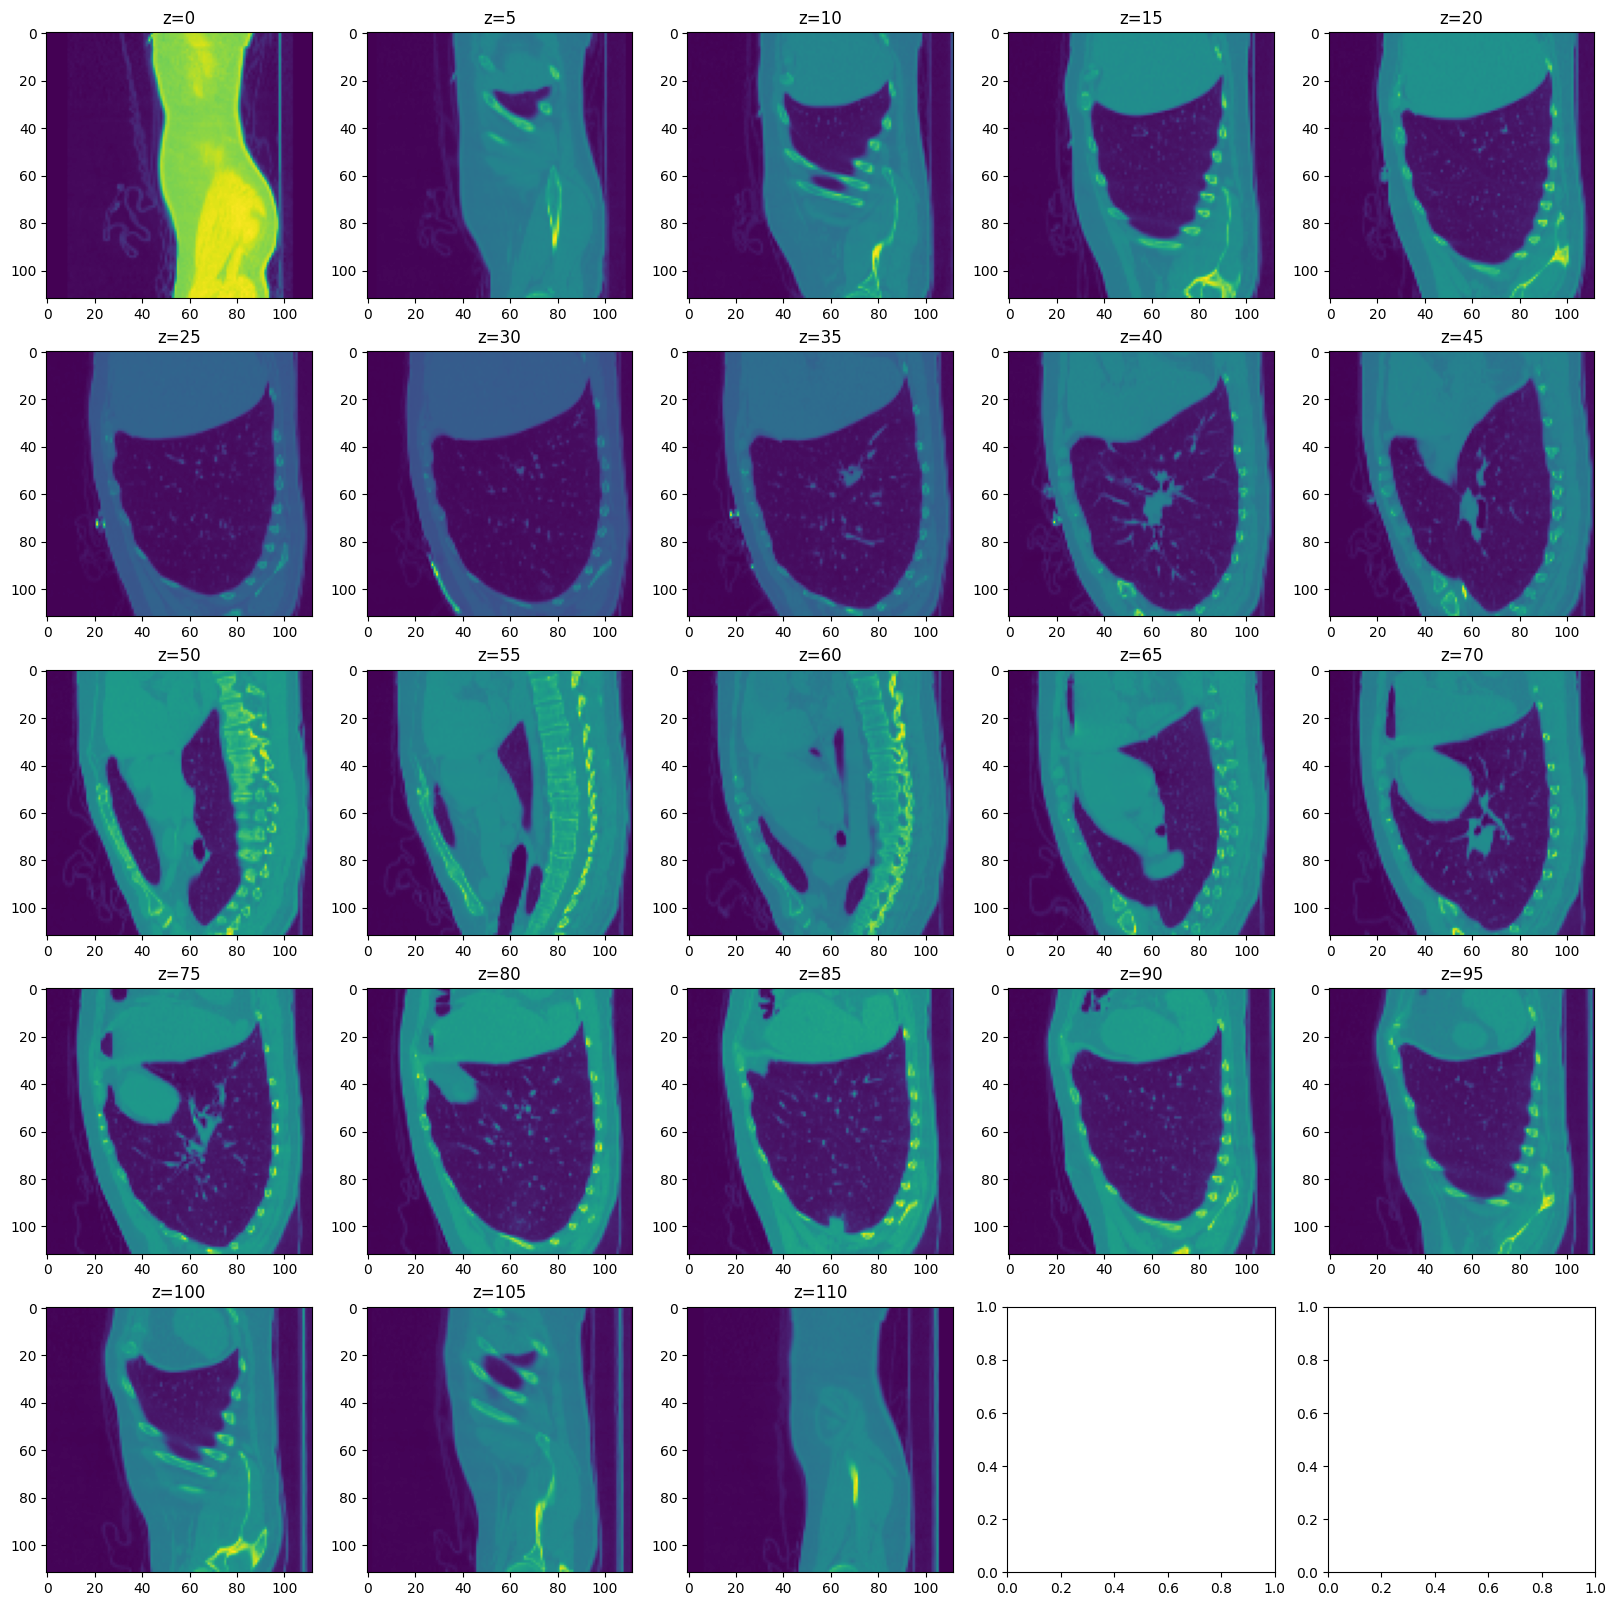

Prediction


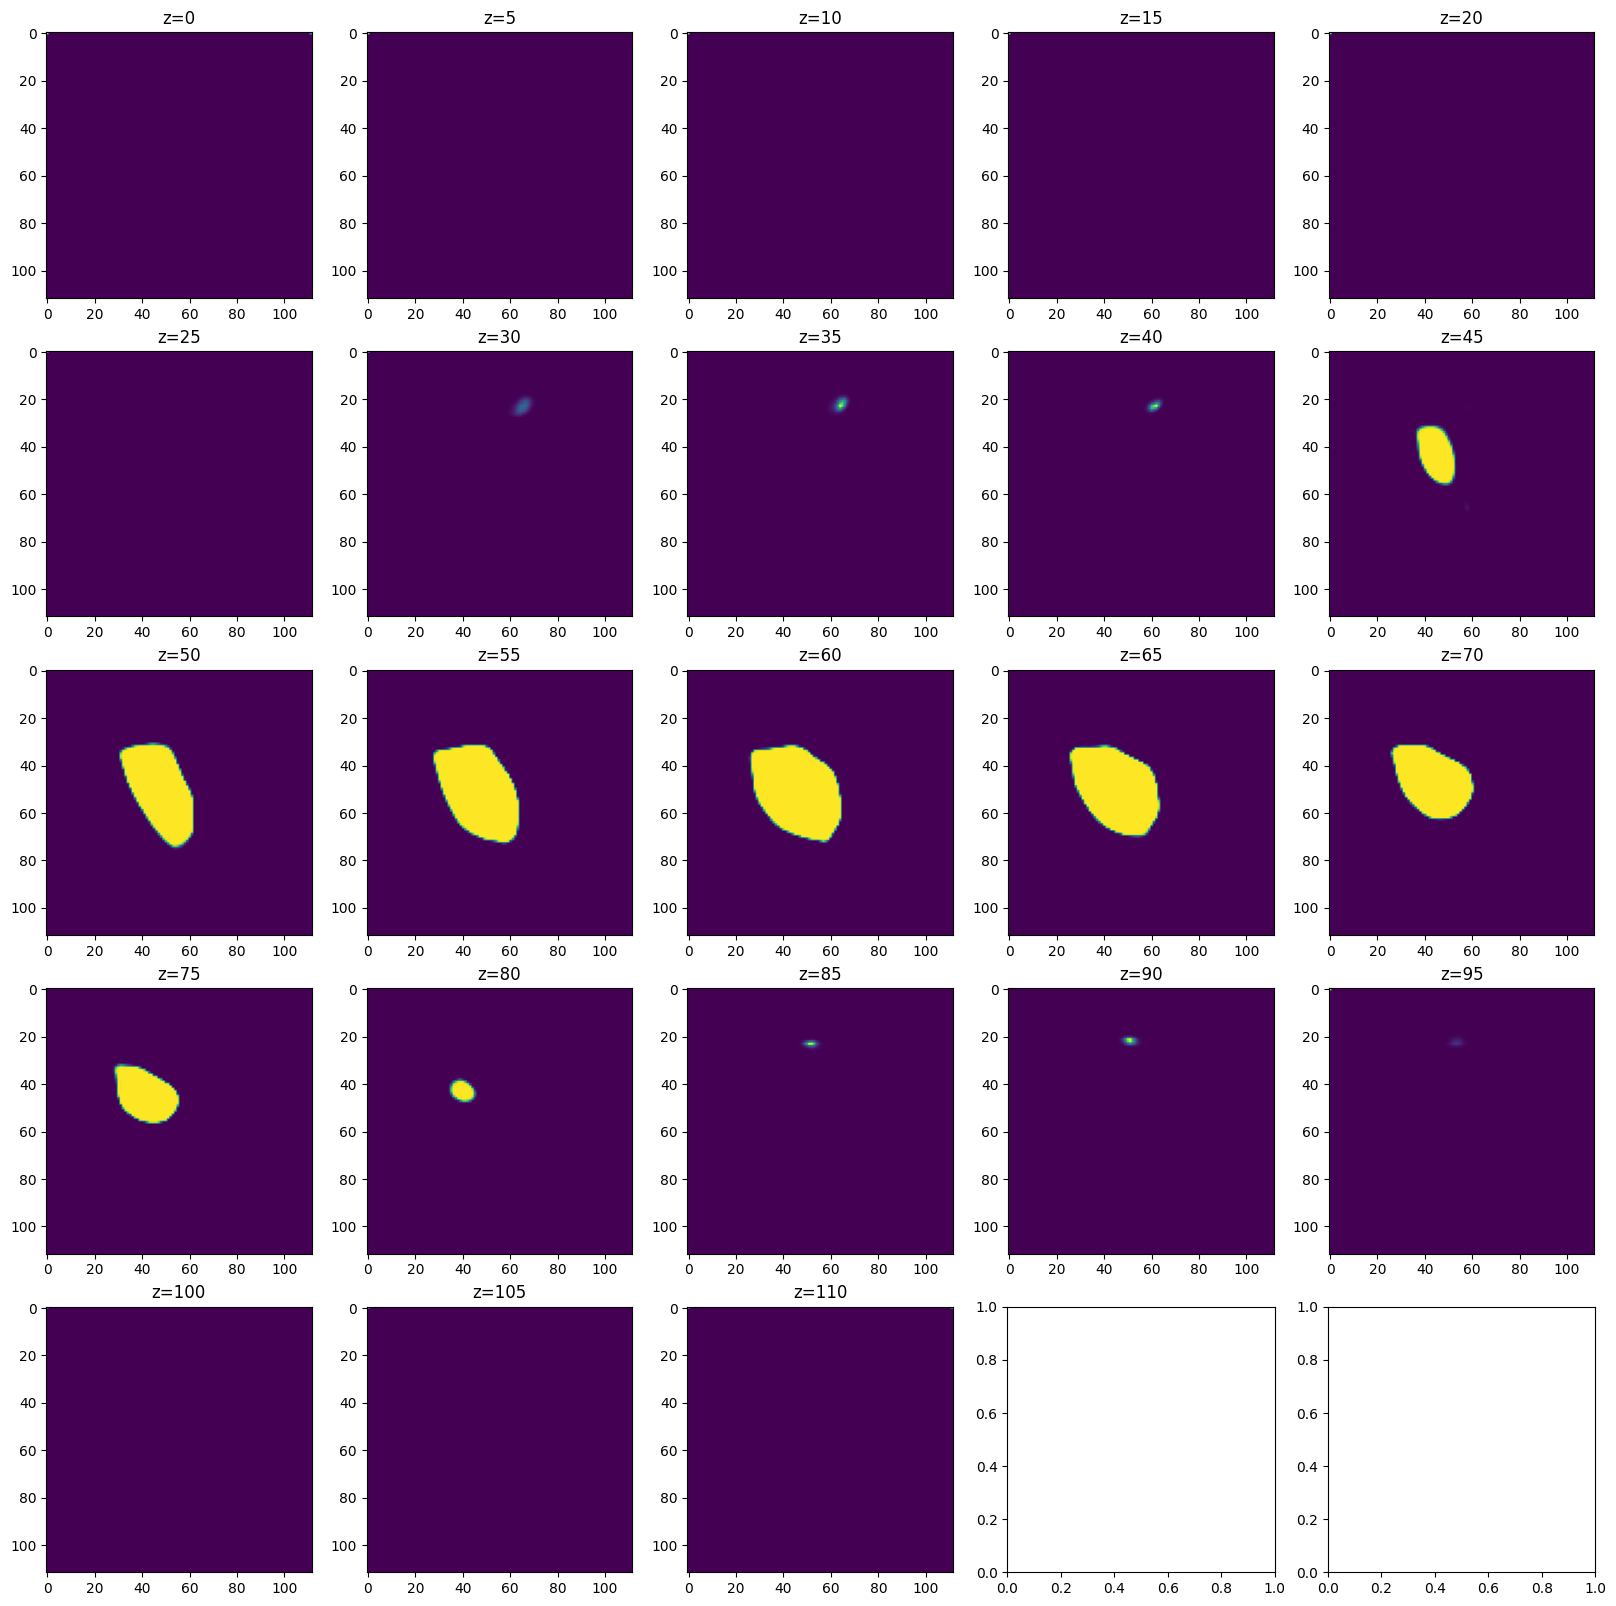

In [ ]:
#visualize inputs and output for the 4 images
for i in range(4):
  print("Input image")
  sliceplot_z(imgsTrue[i], ncols=5, stepsize=5)
  print("Prediction")
  sliceplot_z(msksPred[i], ncols=5, stepsize=5)

In [ ]:
output_dir_npy

'/content/DeepCAC/data/step1_heartloc/model_output/npy'

In [ ]:
!ls {output_dir_npy}

0187_pred.npy  0506_pred.npy  0909_pred.npy  0987_pred.npy


In [ ]:
#code from the 'upsample results' part:
import yaml
import os
yaml_conf = yaml.load(open("/content/DeepCAC/src/config/step1_heart_localization.yaml"),
                      Loader = yaml.FullLoader)
data_folder_path = data_folder_path = os.path.normpath(yaml_conf["io"]["path_to_data_folder"])
heartloc_data_folder_name = yaml_conf["io"]["heartloc_data_folder_name"]
curated_data_folder_name = yaml_conf["io"]["curated_data_folder_name"]
resampled_data_folder_name = yaml_conf["io"]["resampled_data_folder_name"]
upsampled_data_folder_name = yaml_conf["io"]["upsampled_data_folder_name"]
heartloc_data_path = os.path.join(data_folder_path, heartloc_data_folder_name)
curated_dir_path = os.path.join(heartloc_data_path, curated_data_folder_name)
resampled_dir_path = os.path.join(heartloc_data_path, resampled_data_folder_name)
model_output_nrrd_dir_path = os.path.join(heartloc_data_path, upsampled_data_folder_name)
num_cores = 1;

#try to then import the upsample_results function from
# https://github.com/AIM-Harvard/DeepCAC/blob/main/src/step1_heartloc/upsample_results.py
#and call it with the values above

In [ ]:
%cd /content/DeepCAC/src/step1_heartloc

/content/DeepCAC/src/step1_heartloc


In [ ]:
!git pull

Already up to date.


In [ ]:
import sys
from importlib import reload
sys.path.append("/content/DeepCAC/src/")
from step1_heartloc import upsample_results
reload(upsample_results)

model_output_dir_path = "/content/DeepCAC/data/step1_heartloc/model_output"
upsample_results.upsample_results(curated_dir_path, resampled_dir_path, model_output_dir_path, model_output_nrrd_dir_path, num_cores)

#!python upsample_results.py



Data upsampling:
Found 4 patients under "/content/DeepCAC/data/step1_heartloc/curated"
Processing patient 0987
Processing patient 0909
Processing patient 0506
Processing patient 0187


In [ ]:
!ls {model_output_nrrd_dir_path}

0187_pred.nrrd	0506_pred.nrrd	0909_pred.nrrd	0987_pred.nrrd


In [ ]:
print([[patientID], imgsTrue[patientIndex].shape, msksTrue[patientIndex].shape, msksPred[j, :, :, :, 0].shape])

NameError: name 'j' is not defined

In [ ]:
 np.save(os.path.join(output_dir_npy, patientID + '_pred'),
            [[patientID], imgsTrue[patientIndex], msksTrue[patientIndex], msksPred[j, :, :, :, 0]])

NameError: name 'j' is not defined

In [ ]:
def get_input_data_and_make_pred(dataDir, test_file, pkl_file, has_manual_seg, mgpu, model_output_dir_path, model):
  testFileHdf5 = tables.open_file(os.path.join(dataDir, test_file), "r")
  pklData = pickle.load(open(os.path.join(dataDir, pkl_file), 'rb'))
    # Get data in one list for further processing
  testDataRaw = []
  num_test_imgs = len(testFileHdf5.root.ID)
  print(num_test_imgs)
  for i in range(num_test_imgs):
    patientID = (testFileHdf5.root.ID[i]).decode("utf-8") #python 2 to python 3 difference
    img = testFileHdf5.root.img[i]
    if has_manual_seg:
      msk = testFileHdf5.root.msk[i]
    else:  # Create empty dummy has_manual_seg with same size as the image
      sizeImg = len(img)
      msk = np.zeros((sizeImg, sizeImg, sizeImg), dtype=np.float64)
    print(pklData.keys())
    if not patientID in pklData.keys():
      print('Patient not found in pkl data', patientID)
      continue
    zDif = pklData[patientID][6][2]
    testDataRaw.append([patientID, img, msk, zDif])

  numData = len(testDataRaw)
  size = len(testDataRaw[0][1])
  imgsTrue = np.zeros((numData, size, size, size), dtype=np.float64)
  msksTrue = np.zeros((numData, size, size, size), dtype=np.float64)

  for i in range(0, len(testDataRaw) + 1, mgpu):
    imgTest = np.zeros((4, size, size, size), dtype=np.float64)

    for j in range(mgpu):
      # If the number of test images is not mod 4 == 0, just redo the last file severall times
      patientIndex = min(len(testDataRaw) - 1, i + j)
      patientID = testDataRaw[patientIndex][0]
      print('Processing patient', patientID)
      # Store data for score calculation
      imgsTrue[patientIndex, :, :, :] = testDataRaw[patientIndex][1]
      msksTrue[patientIndex, :, :, :] = testDataRaw[patientIndex][2]
      imgTest[j, :, :, :] = testDataRaw[patientIndex][1]


  msksPred = model.predict(imgTest[:, :, :, :, np.newaxis])
  output_dir_npy = os.path.join(model_output_dir_path, 'npy')

  for j in range(mgpu):
    patientIndex = min(len(testDataRaw) - 1, i + j)
    patientID = testDataRaw[patientIndex][0]
    np.save(os.path.join(output_dir_npy, patientID + '_pred'),
              [[patientID], imgsTrue[patientIndex], msksTrue[patientIndex], msksPred[j, :, :, :, 0]])
              #[[patientID], imgsTrue[patientIndex, :, :, :], msksTrue[patientIndex, :, :, :], msksPred[j, :, :, :, 0]])

get_input_data_and_make_pred(
    dataDir="/content/DeepCAC/data/step1_heartloc/model_input", #model_input_dir_path
    test_file="step1_test_data.h5",
    pkl_file="step1_downsample_results.pkl",
    has_manual_seg=True,
    mgpu=1,
    model_output_dir_path = "/content/DeepCAC/data/step1_heartloc/model_output",
    model=model_without_weights)

In [ ]:
model_preds = model_without_weights.predict(input_data_to_model[0:1])


In [ ]:
sliceplot_z(input_data_to_model[0], ncols=5, stepsize=5)

For visualizing input data:

In [ ]:
import numpy as np
import nrrd
readdata, header = nrrd.read('/content/DeepCAC/data/raw/0187/img.nrrd')
print(readdata.shape)
sliceplot_z(readdata, ncols=5, stepsize=5)

In [ ]:
!pip install SimpleITK

Step 2 Code

In [ ]:
!git pull

Already up to date.


In [ ]:
%cd /content/DeepCAC/src

/content/DeepCAC/src


In [ ]:
!python run_step2_heart_segmentation.py

Traceback (most recent call last):
  File "/content/DeepCAC/src/run_step2_heart_segmentation.py", line 23, in <module>
    from step2_heartseg import compute_bbox, crop_data, input_data_prep, run_inference, upsample_results, compute_metrics
  File "/content/DeepCAC/src/step2_heartseg/run_inference.py", line 19, in <module>
    import heartseg_model
  File "/content/DeepCAC/src/step2_heartseg/heartseg_model.py", line 26, in <module>
    from tensorflow.keras.layers.merge import concatenate
ModuleNotFoundError: No module named 'tensorflow.keras.layers.merge'


In [ ]:
!python run_step3_cac_segmentation.py


--- STEP 3 - CAC SEGMENTATION ---

Segmentation masks dilation:
Found 0 patients under "../data/step2_heartseg/model_output_nrrd"
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()

Heart cropping:
Found 0 files under "../data/step3_cacseg/dilated"

Deep Learning model inference using 4xGPUs:
Found 0 patients under "../data/step3_cacseg/cropped"
Loading saved model from "../data/step3_cacseg/model_weights/step3_cacseg_model_weights.hdf5"
Traceback (most recent call last):
  File "/content/DeepCAC/src/run_step3_cac_segmentation.py", line 154, in <module>
    run_inference.run_inference(data_dir = cropped_dir_name,
  File "/content/DeepCAC/src/step3_cacseg/run_inference.py", line 214, in run_inference
    model.load_weights(weights_file)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/tracebac